## Import required packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.impute import SimpleImputer
import itertools
import warnings
warnings.filterwarnings("ignore")

## Define functions to be used later

In [2]:
def standardize_columns(df):
    '''Function to convert column names of the imported dataframe to our standard'''
    
    if not len(df.columns) == 0 and len(df.columns) == 12:
        columns = list(df.columns)
        columns[0] = 'Person_ID'
        columns[1] = 'TPA_Claim_ID'
        columns[2] = 'Claim_Type'
        columns[3] = 'ICD_10'
        columns[4] = 'NDC_Name'
        columns[5] = 'Therapeutic_Class_Name'
        columns[6] = 'Days_Supply'
        columns[7] = 'Refills'
        columns[8] = 'Amount_Allowed'
        columns[9] = 'Plan'
        columns[10] = 'Start_Date'
        columns[11] = 'End_Date'
        df.columns = columns
    else:
        print("DataFrame is empty or does not have the correct number of columns.")
    
    return df

In [3]:
def validate_dtypes(df):
    '''Function to validate data types'''

    df = df.replace(',','', regex=True)

    str_cols = ['TPA_Claim_ID', 'Claim_Type', 'ICD_10', 'NDC_Name', 'Therapeutic_Class_Name']
    date_cols = ['Start_Date', 'End_Date']
    int_cols = ['Person_ID', 'Days_Supply', 'Refills']
    numeric_cols = ['Amount_Allowed']
    
    error_messages = []

    for col in str_cols:     
        valid_values = df[col].apply(lambda x: isinstance(x, str) or pd.isna(x))
        if not valid_values.all():
            error_messages.append(f"Column '{col}' contains values that are not strings or NaN.")
            

    for col in date_cols:
        try:
            pd.to_datetime(df[col], errors='raise')
        except (TypeError, ValueError):
            error_messages.append(f"Column '{col}' does not contain valid date values.")
            

    for col in int_cols:
        valid_values = df[col].apply(lambda x: isinstance(x, int))
        if not valid_values.all():
            error_messages.append(f"Column '{col}' contains values that are not integers.")
            

    for col in numeric_cols:
        valid_values = pd.to_numeric(df[col], errors='coerce').notnull()
        if not valid_values.all():
            error_messages.append(f"Column '{col}' contains values that are not numeric.")
          
    if not error_messages:
        print("All specified columns contain valid data types.")
    else:
        for message in error_messages:
            print(message)

In [4]:
def validate_claims(df):
    df.dropna(subset=['Claim_Type'], inplace=True)
    valid_values = df['Claim_Type'].str.lower().isin(['med', 'rx'])
    
    if valid_values.all():
        print("All values in the Claim_Type column are either 'MED' or 'Rx'.")
        
    else:
        print("The Claim_Type column contains values other than 'MED' or 'Rx'.")

In [5]:
def date_aggregate(df):
    ''' Function to aggregate the days supply and allowed amount for each date '''

    df = df.replace(',','', regex=True)
    df['Amount_Allowed'] = pd.to_numeric(df['Amount_Allowed'])
    df_grouped =  df.groupby('Start_Date').agg({'Days_Supply': 'sum', 'Amount_Allowed': 'sum'}).reset_index()
    df_trimmed = df.drop(['Days_Supply', 'Amount_Allowed'], axis=1).drop_duplicates('Start_Date')
    df = pd.merge(df_trimmed, df_grouped, on='Start_Date')
    
    # Only keep rows where aggregated days supply and aggregated amount allowed are both positive
    df = df[(df['Days_Supply'] > 0) & (df['Amount_Allowed'] > 0)]
    
    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    df['End_Date'] = pd.to_datetime(df['End_Date'])
    
    df.sort_values('Start_Date', inplace = True)
    df = df.reset_index(drop=True)
    
    df['Total_Amount_Allowed'] = df['Amount_Allowed'].sum()
   
    return df

In [6]:
# MPR is a measure of medication adherence based on pharmacy refill records
# A higher MPR means higher adherence
# An MPR >= 0.80 means an individual can be classed as adherent

def mpr(df):
    ''' Function to calculate Medication Possesseion Ratio (MPR) '''
    
    tot_med_supply = df.iloc[:-1]['Days_Supply'].sum()
    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    days_in_interval = (df['Start_Date'].iloc[-1] - df['Start_Date'].iloc[0]).days 
    res = np.round(tot_med_supply / days_in_interval, 2)
    df['Adherence_(MPR)'] = res
    
    # Capping MPR at 1.0
    df['Adherence_(MPR)'] = df['Adherence_(MPR)'].apply(lambda x: min(1, x))
    
    res_df = df[['Person_ID', 'TPA_Claim_ID', 'NDC_Name', 'Therapeutic_Class_Name', 'Total_Amount_Allowed', 'Adherence_(MPR)']].iloc[0].to_frame().transpose()
    res_df['Class'] = res_df['Adherence_(MPR)'].apply(lambda x: 'Adherent' if x >= 0.80 else 'Not Adherent')
    return res_df

In [7]:
def generate_mpr_results(df):
    ''' Function to generate a dataframe containing the MPR results for the Rx data'''

    unique_combinations = df[['Person_ID', 'NDC_Name']].drop_duplicates()
    res_df = pd.DataFrame()
    
    for idx, row in unique_combinations.iterrows():
        person_id = row['Person_ID']
        ndc_name = row['NDC_Name']
    
        subset_df = df[(df['Person_ID'] == person_id) & (df['NDC_Name'] == ndc_name)]
        agg_df = date_aggregate(subset_df)
    
        # This condition is needed to filter out single claims that will have an artificially high MPR of 1.0
        if len(agg_df) > 1:
            result = mpr(agg_df)
            res_df =  pd.concat([res_df, result], ignore_index=True)

    res_df['Expenditure'] = res_df['Total_Amount_Allowed'] * res_df['Adherence_(MPR)']
    res_df['Expenditure'] = res_df['Expenditure'].astype(float).round(2)
    res_df['Loss'] = res_df['Total_Amount_Allowed'] - res_df['Expenditure']
        

    return res_df

In [8]:
def cost_and_claims_per_month(df):
    ''' Function to compute cost and claim count per month per person'''
    
    df = df.replace(',','', regex=True)
    df['Start_Date'] = pd.to_datetime(df['Start_Date'])
    df['Year_Month'] = df['Start_Date'].dt.to_period('M')
    df['Amount_Allowed'] = pd.to_numeric(df['Amount_Allowed'])
    
    result_df = df.groupby(['Person_ID', 'Year_Month']).agg({'Amount_Allowed': 'sum', 'Start_Date': 'count'}).reset_index()
    result_df.columns = ['Person_ID', 'Year_Month', 'Total_Cost', 'Claim_Count']

    result_df.sort_values('Year_Month', inplace = True)
    result_df = result_df.reset_index(drop=True)
    
    
    return result_df

In [9]:
def calculate_preventive_claim_ratio(df):
    '''Function to calculate ratio of preventive claims to total claims'''
    
    df = df.replace(',','', regex=True)
    df['Amount_Allowed'] = pd.to_numeric(df['Amount_Allowed'])
    df = df[df['Amount_Allowed'] != 0]
    df['Year_Month'] = pd.to_datetime(df['Start_Date']).dt.to_period('M')
    
    agg_df = df.groupby('Year_Month')['Amount_Allowed'].sum().reset_index()
    df['Preventive'] = df['ICD_10'].str.lower().str.startswith("z", na=False)
    df['Not_Preventive'] = ~df['ICD_10'].str.lower().str.startswith("z", na=False)
    counts = df.groupby('Year_Month')[['Preventive', 'Not_Preventive']].sum().reset_index()
    
    agg_df = agg_df.merge(counts, on='Year_Month', how='left')
    agg_df['Total_Claims'] = agg_df['Preventive'] + agg_df['Not_Preventive']
    agg_df['Preventive_Claim_Ratio'] = agg_df['Preventive'] / agg_df['Total_Claims']
    
    return agg_df

In [10]:
def generate_wellness_data(med_df, employee_counts_df):
    '''Function to generate final wellness data dataframes'''
    
    wellness_df = calculate_preventive_claim_ratio(med_df)
    wellness_df = pd.merge(wellness_df, employee_counts_df)
    wellness_df['Cost_per_Claim'] = wellness_df['Amount_Allowed'] / wellness_df['Total_Claims']
    wellness_df['Cost_per_Employee'] = wellness_df['Amount_Allowed'] / wellness_df['Employee_Count'] 
    
    return wellness_df

In [11]:
def employee_count_by_plan(df):
    '''Function to calculate the total employee count for each plan'''

    melted_df = pd.melt(df, id_vars=['Plan', 'Plan_Type', 'Company_Coverage'], var_name='Year_Month', value_name='Employee_Count')

    result = melted_df.groupby(['Plan', 'Plan_Type', 'Year_Month'])['Employee_Count'].sum().reset_index()

    return result

In [12]:
# Read in data
Company8_df = pd.read_csv("data/Company8_med_and_rx.csv")
Company5_df = pd.read_csv("data/Company5_med_and_rx.csv")
Company1_df = pd.read_csv("data/Company1_med_and_rx.csv")
Company2_df = pd.read_csv("data/Company2_med_and_rx.csv")
Company3_df = pd.read_csv("data/Company3_med_and_rx.csv")
Company4_df = pd.read_csv("data/Company4_med_and_rx.csv")
Company6_df = pd.read_csv("data/Company6_med_and_rx.csv")
Company7_df = pd.read_csv("data/Company7_med_and_rx.csv")

In [13]:
Company8_df = standardize_columns(Company8_df)
Company5_df = standardize_columns(Company5_df)
Company1_df = standardize_columns(Company1_df)
Company2_df = standardize_columns(Company2_df)
Company3_df = standardize_columns(Company3_df)
Company4_df = standardize_columns(Company4_df)
Company6_df = standardize_columns(Company6_df)
Company7_df = standardize_columns(Company7_df)

In [14]:
# print(validate_dtypes(Company8_df))
# print(validate_dtypes(Company5_df))
# print(validate_dtypes(Company1_df))
# print(validate_dtypes(Company2_df))
# print(validate_dtypes(Company3_df))
# print(validate_dtypes(Company4_df))
# print(validate_dtypes(Company6_df))
# print(validate_dtypes(Company7_df))

In [15]:
# print(validate_claims(Company8_df))
# print(validate_claims(Company5_df))
# print(validate_claims(Company1_df))
# print(validate_claims(Company2_df))
# print(validate_claims(Company3_df))
# print(validate_claims(Company4_df))
# print(validate_claims(Company6_df))
# print(validate_claims(Company7_df))

In [16]:
# Read in data that contain plan types
Company1_byPlan1 = pd.read_csv("data/Company1_byPlan1.csv")
Company1_byPlan2 = pd.read_csv("data/Company1_byPlan2.csv")
Company1_byPlan3 = pd.read_csv("data/Company1_byPlan3.csv")
Company1_byPlan1 = employee_count_by_plan(Company1_byPlan1)
Company1_byPlan2 = employee_count_by_plan(Company1_byPlan2)
Company1_byPlan3 = employee_count_by_plan(Company1_byPlan3)
Company1_byPlan = pd.concat([Company1_byPlan1, Company1_byPlan2, Company1_byPlan3], ignore_index=True)

Company3_byPlan1 = pd.read_csv("data/Company3_byPlan1.csv")
Company3_byPlan2 = pd.read_csv("data/Company3_byPlan2.csv")
Company3_byPlan3 = pd.read_csv("data/Company3_byPlan3.csv")
Company3_byPlan1 = employee_count_by_plan(Company3_byPlan1)
Company3_byPlan2 = employee_count_by_plan(Company3_byPlan2)
Company3_byPlan3 = employee_count_by_plan(Company3_byPlan3)
Company3_byPlan = pd.concat([Company3_byPlan1, Company3_byPlan2, Company3_byPlan3], ignore_index=True)

Company4_byPlan1 = pd.read_csv("data/Company4_byPlan1.csv")
Company4_byPlan2 = pd.read_csv("data/Company4_byPlan2.csv")
Company4_byPlan3 = pd.read_csv("data/Company4_byPlan3.csv")
Company4_byPlan1 = employee_count_by_plan(Company4_byPlan1)
Company4_byPlan2 = employee_count_by_plan(Company4_byPlan2)
Company4_byPlan3 = employee_count_by_plan(Company4_byPlan3)
Company4_byPlan = pd.concat([Company4_byPlan1, Company4_byPlan2, Company4_byPlan3], ignore_index=True)

Company5_byPlan1 = pd.read_csv("data/Company5_byPlan1.csv")
Company5_byPlan2 = pd.read_csv("data/Company5_byPlan2.csv")
Company5_byPlan1 = employee_count_by_plan(Company5_byPlan1)
Company5_byPlan2 = employee_count_by_plan(Company5_byPlan2)
Company5_byPlan = pd.concat([Company5_byPlan1, Company5_byPlan2], ignore_index=True)

Company6_byPlan = pd.read_csv("data/Company6_byPlan.csv")
Company6_byPlan = employee_count_by_plan(Company6_byPlan)

Company7_byPlan1 = pd.read_csv("data/Company7_byPlan1.csv")
Company7_byPlan2 = pd.read_csv("data/Company7_byPlan2.csv")
Company7_byPlan3 = pd.read_csv("data/Company7_byPlan3.csv")
Company7_byPlan1 = employee_count_by_plan(Company7_byPlan1)
Company7_byPlan2 = employee_count_by_plan(Company7_byPlan2)
Company7_byPlan3 = employee_count_by_plan(Company7_byPlan3)
Company7_byPlan = pd.concat([Company7_byPlan1, Company7_byPlan2, Company7_byPlan3], ignore_index=True)

Company8_byPlan1 = pd.read_csv("data/Company8_byPlan1.csv")
Company8_byPlan2 = pd.read_csv("data/Company8_byPlan2.csv")
Company8_byPlan3 = pd.read_csv("data/Company8_byPlan3.csv")
Company8_byPlan1 = employee_count_by_plan(Company8_byPlan1)
Company8_byPlan2 = employee_count_by_plan(Company8_byPlan2)
Company8_byPlan3 = employee_count_by_plan(Company8_byPlan3)
Company8_byPlan = pd.concat([Company8_byPlan1,Company8_byPlan2, Company8_byPlan3], ignore_index=True)

Company2_byPlan1 = pd.read_csv("data/Company2_byPlan1.csv") 
Company2_byPlan2 = pd.read_csv("data/Company2_byPlan2.csv")
Company2_byPlan3 = pd.read_csv("data/Company2_byPlan3.csv")
Company2_byPlan4 = pd.read_csv("data/Company2_byPlan4.csv")
Company2_byPlan1 = employee_count_by_plan(Company2_byPlan1)
Company2_byPlan2 = employee_count_by_plan(Company2_byPlan2)
Company2_byPlan3 = employee_count_by_plan(Company2_byPlan3)
Company2_byPlan4 = employee_count_by_plan(Company2_byPlan4)
Company2_byPlan = pd.concat([Company2_byPlan1, Company2_byPlan2, Company2_byPlan3, Company2_byPlan4], ignore_index=True)

In [17]:
# Join tables to add plan type to the master data frames
Company1_plan_type_df = Company1_byPlan[['Plan', 'Plan_Type']]
Company1_df = Company1_df.merge(Company1_plan_type_df, on='Plan', how='left')
Company8_plan_type_df = Company8_byPlan[['Plan', 'Plan_Type']]
Company8_df = Company8_df.merge(Company8_plan_type_df, on='Plan', how='left')
Company5_plan_type_df = Company5_byPlan[['Plan', 'Plan_Type']]
Company5_df = Company5_df.merge(Company5_plan_type_df, on='Plan', how='left')
Company2_plan_type_df = Company2_byPlan[['Plan', 'Plan_Type']]
Company2_df = Company2_df.merge(Company2_plan_type_df, on='Plan', how='left')
Company3_plan_type_df = Company3_byPlan[['Plan', 'Plan_Type']]
Company3_df = Company3_df.merge(Company3_plan_type_df, on='Plan', how='left')
Company4_plan_type_df = Company4_byPlan[['Plan', 'Plan_Type']]
Company4_df = Company4_df.merge(Company4_plan_type_df, on='Plan', how='left')
Company6_plan_type_df = Company6_byPlan[['Plan', 'Plan_Type']]
Company6_df = Company6_df.merge(Company6_plan_type_df, on='Plan', how='left')
Company7_plan_type_df = Company7_byPlan[['Plan', 'Plan_Type']]
Company7_df = Company7_df.merge(Company7_plan_type_df, on='Plan', how='left')

In [18]:
# Separate Rx and Medical claims
Company8_rx_data = Company8_df[Company8_df["Claim_Type"] == "Rx"]
Company8_med_data = Company8_df[Company8_df["Claim_Type"] == "MED"]
Company5_rx_data = Company5_df[Company5_df["Claim_Type"] == "Rx"]
Company5_med_data = Company5_df[Company5_df["Claim_Type"] == "MED"]
Company1_rx_data = Company1_df[Company1_df["Claim_Type"] == "Rx"]
Company1_med_data = Company1_df[Company1_df["Claim_Type"] == "MED"]
Company2_rx_data = Company2_df[Company2_df["Claim_Type"] == "Rx"]
Company2_med_data = Company2_df[Company2_df["Claim_Type"] == "MED"]
Company3_rx_data = Company3_df[Company3_df["Claim_Type"] == "Rx"]
Company3_med_data = Company3_df[Company3_df["Claim_Type"] == "MED"]
Company4_rx_data = Company4_df[Company4_df["Claim_Type"] == "Rx"]
Company4_med_data = Company4_df[Company4_df["Claim_Type"] == "MED"]
Company6_rx_data = Company6_df[Company6_df["Claim_Type"] == "Rx"]
Company6_med_data = Company6_df[Company6_df["Claim_Type"] == "MED"]
Company7_rx_data = Company7_df[Company7_df["Claim_Type"] == "Rx"]
Company7_med_data = Company7_df[Company7_df["Claim_Type"] == "MED"]

In [19]:
# Generate MPR results
Company8_res_df = generate_mpr_results(Company8_rx_data)
Company5_res_df = generate_mpr_results(Company5_rx_data)
Company1_res_df = generate_mpr_results(Company1_rx_data)
Company2_res_df = generate_mpr_results(Company2_rx_data)
Company3_res_df = generate_mpr_results(Company3_rx_data)
Company4_res_df = generate_mpr_results(Company4_rx_data)
Company6_res_df = generate_mpr_results(Company6_rx_data)
Company7_res_df = generate_mpr_results(Company7_rx_data)

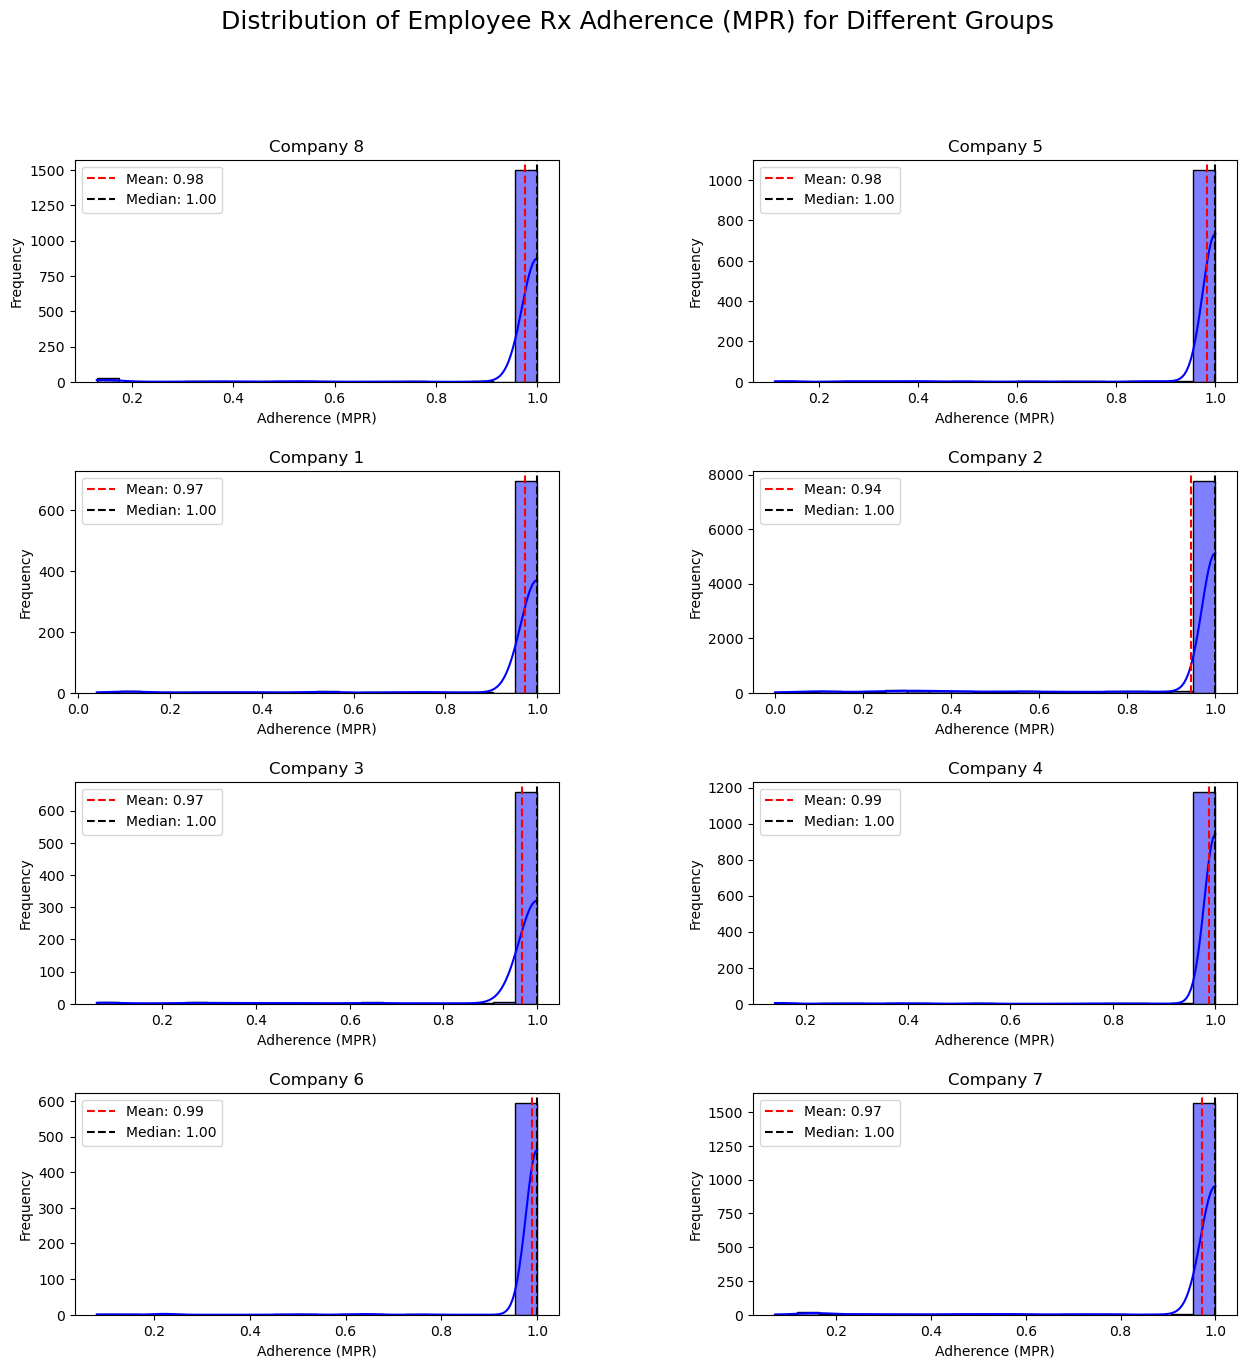

In [20]:
# Distribution of Rx Adherence (MPR)
data_frames = [Company8_res_df, Company5_res_df, Company1_res_df, Company2_res_df, Company3_res_df, Company4_res_df, Company6_res_df, Company7_res_df]
titles = ['Company 8', 'Company 5', 'Company 1', 'Company 2', 'Company 3', 'Company 4', 'Company 6', 'Company 7']

rows = 4
cols = 2

fig, axs = plt.subplots(rows, cols, figsize=(15, 15), gridspec_kw={'wspace': 0.4, 'hspace': 0.4})

for i, ax in enumerate(axs.flat):
    sns.histplot(data_frames[i]['Adherence_(MPR)'], bins=20, kde=True, color='blue', ax=ax)
    ax.set_title(titles[i])
    ax.set_xlabel('Adherence (MPR)')
    ax.set_ylabel('Frequency')
    mean_adherence = data_frames[i]['Adherence_(MPR)'].mean()
    median_adherence = data_frames[i]['Adherence_(MPR)'].median()
    ax.axvline(mean_adherence, color='red', linestyle='--', label=f'Mean: {mean_adherence:.2f}')
    ax.axvline(median_adherence, color='black', linestyle='--', label=f'Median: {median_adherence:.2f}')
    ax.legend()

plt.suptitle('Distribution of Employee Rx Adherence (MPR) for Different Groups', fontsize=18)
plt.tight_layout()
plt.show()

In [21]:
# Read data for employee counts
Company8_EmployeeCounts = pd.read_csv('data/Company8_EmployeeCounts.csv')
Company5_EmployeeCounts = pd.read_csv('data/Company5_EmployeeCounts.csv')
Company1_EmployeeCounts = pd.read_csv('data/Company1_EmployeeCounts.csv')
Company2_EmployeeCounts = pd.read_csv('data/Company2_EmployeeCounts.csv')
Company3_EmployeeCounts = pd.read_csv('data/Company3_EmployeeCounts.csv')
Company4_EmployeeCounts = pd.read_csv('data/Company4_EmployeeCounts.csv')
Company6_EmployeeCounts = pd.read_csv('data/Company6_EmployeeCounts.csv')
Company7_EmployeeCounts = pd.read_csv('data/Company7_EmployeeCounts.csv')

In [22]:
Employee_Counts_list = [Company8_EmployeeCounts, Company5_EmployeeCounts, Company1_EmployeeCounts,
                        Company2_EmployeeCounts, Company3_EmployeeCounts, Company4_EmployeeCounts,
                        Company6_EmployeeCounts, Company7_EmployeeCounts]

In [23]:
for df in Employee_Counts_list:
    df['Year_Month'] = pd.to_datetime(df['Year_Month']).dt.to_period('M')
    df['Employee_Count'] = pd.to_numeric(df['Employee_Count'], errors='coerce')

In [24]:
# Generate wellness data for all clients
Company8_wellness_df = generate_wellness_data(Company8_med_data, Company8_EmployeeCounts)
Company8_wellness_df['Firm'] = 'Company 8' 

In [25]:
Company5_wellness_df = generate_wellness_data(Company5_med_data, Company5_EmployeeCounts)
Company5_wellness_df['Firm'] = 'Company 5'

In [26]:
Company1_wellness_df = generate_wellness_data(Company1_med_data, Company1_EmployeeCounts)
Company1_wellness_df['Firm'] = 'Company 1'

In [27]:
Company2_wellness_df = generate_wellness_data(Company2_med_data, Company2_EmployeeCounts)
Company2_wellness_df['Firm'] = 'Company 2'

In [28]:
Company3_wellness_df = generate_wellness_data(Company3_med_data, Company3_EmployeeCounts)
Company3_wellness_df['Firm'] = 'Company 3'

In [29]:
Company4_wellness_df = generate_wellness_data(Company4_med_data, Company4_EmployeeCounts)
Company4_wellness_df['Firm'] = 'Company 4'

In [30]:
Company6_wellness_df = generate_wellness_data(Company6_med_data, Company6_EmployeeCounts)
Company6_wellness_df['Firm'] = 'Company 6'

In [31]:
Company7_wellness_df = generate_wellness_data(Company7_med_data, Company7_EmployeeCounts)
Company7_wellness_df['Firm'] = 'Company 7'

In [32]:
wellness_dfs = [Company8_wellness_df, Company5_wellness_df, Company1_wellness_df, Company2_wellness_df, Company3_wellness_df, Company4_wellness_df, Company6_wellness_df, Company7_wellness_df]

In [33]:
for df in wellness_dfs:
    df.drop(df.index[-1], inplace=True)
    df['Amount_Allowed_6_month_avg'] = pd.to_numeric(df['Amount_Allowed'].rolling(window=6).mean(), errors='coerce')
    df['Preventive_Claim_Ratio_6_month_avg'] = pd.to_numeric(df['Preventive_Claim_Ratio'].rolling(window=6).mean(), errors='coerce')
    df['Cost_per_Claim_6_month_avg'] = pd.to_numeric(df['Cost_per_Claim'].rolling(window=6).mean(), errors='coerce')
    df['Cost_per_Employee_6_month_avg'] = pd.to_numeric(df['Cost_per_Employee'].rolling(window=6).mean(), errors='coerce')
    df['Cost_per_Claim_3_month_avg'] = pd.to_numeric(df['Cost_per_Claim'].rolling(window=3).mean(), errors='coerce')
    df['Cost_per_Employee_3_month_avg'] = pd.to_numeric(df['Cost_per_Employee'].rolling(window=3).mean(), errors='coerce')

In [34]:
all_wellness_df = pd.concat(wellness_dfs, ignore_index=True)
all_wellness_df['Year_Month'] = all_wellness_df['Year_Month'].dt.strftime('%Y-%m')
all_wellness_df.drop(all_wellness_df.index[-1], inplace=True)

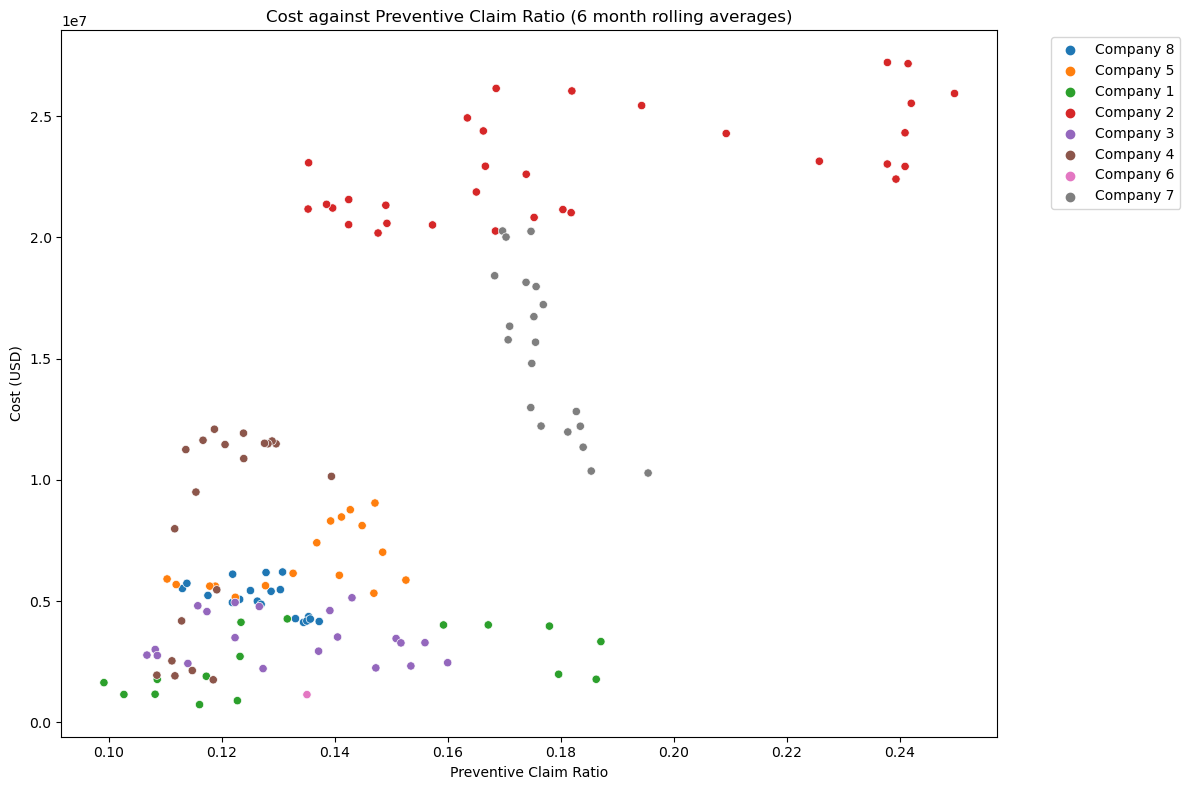

In [35]:
# Plotting Cost against PCR
plt.figure(figsize=(12, 8))
sns.scatterplot(data=all_wellness_df, x='Preventive_Claim_Ratio_6_month_avg', y='Amount_Allowed_6_month_avg', hue='Firm', palette='tab10')
plt.title('Cost against Preventive Claim Ratio (6 month rolling averages)')
plt.xlabel('Preventive Claim Ratio')
plt.ylabel('Cost (USD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left') 
plt.tight_layout() 
plt.show()

## Classification Model: K-Means

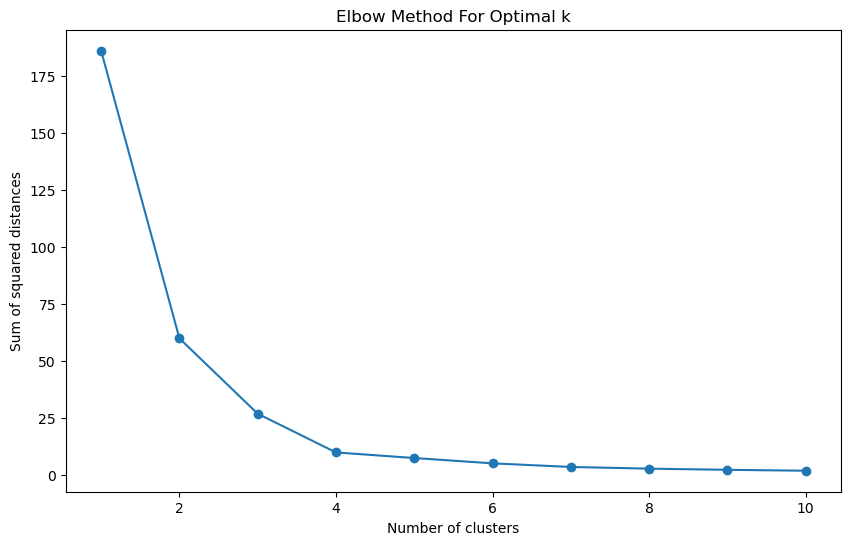

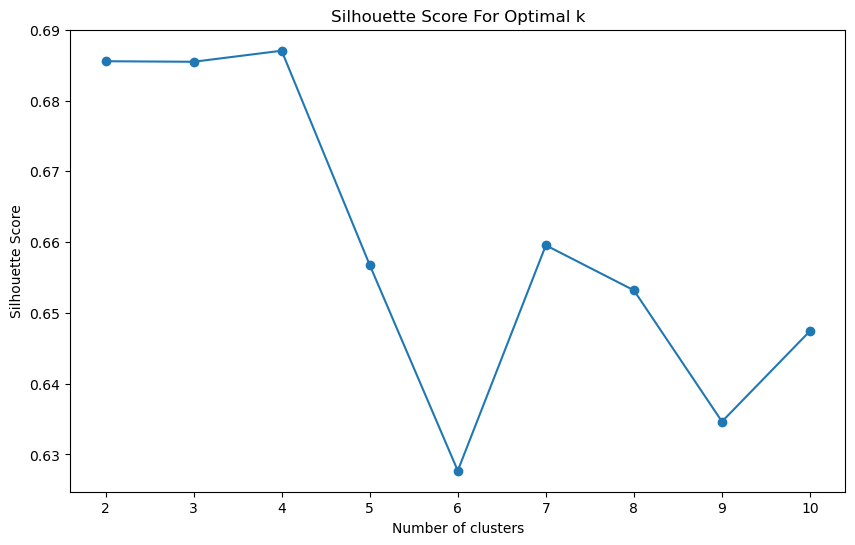

In [36]:
# Handle NaN values using median imputation
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(all_wellness_df[['Preventive_Claim_Ratio_6_month_avg']])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)

# Elbow Method
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.show()

# Silhouette Scores
silhouette_scores = []
for k in range(2, 11):  # silhouette score is not defined for k=1
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(data_scaled)
    silhouette_scores.append(silhouette_score(data_scaled, cluster_labels))

plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.title('Silhouette Score For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()


Silhouette Score for k=4: 0.69
Cluster     0   1   2   3
Firm                     
Company 1   6   6   9   0
Company 2  15  12   0  10
Company 3  14   1  10   0
Company 4   7   0  18   0
Company 5  16   0   6   0
Company 6   6   0   0   0
Company 7   5  20   0   0
Company 8  13   0  12   0


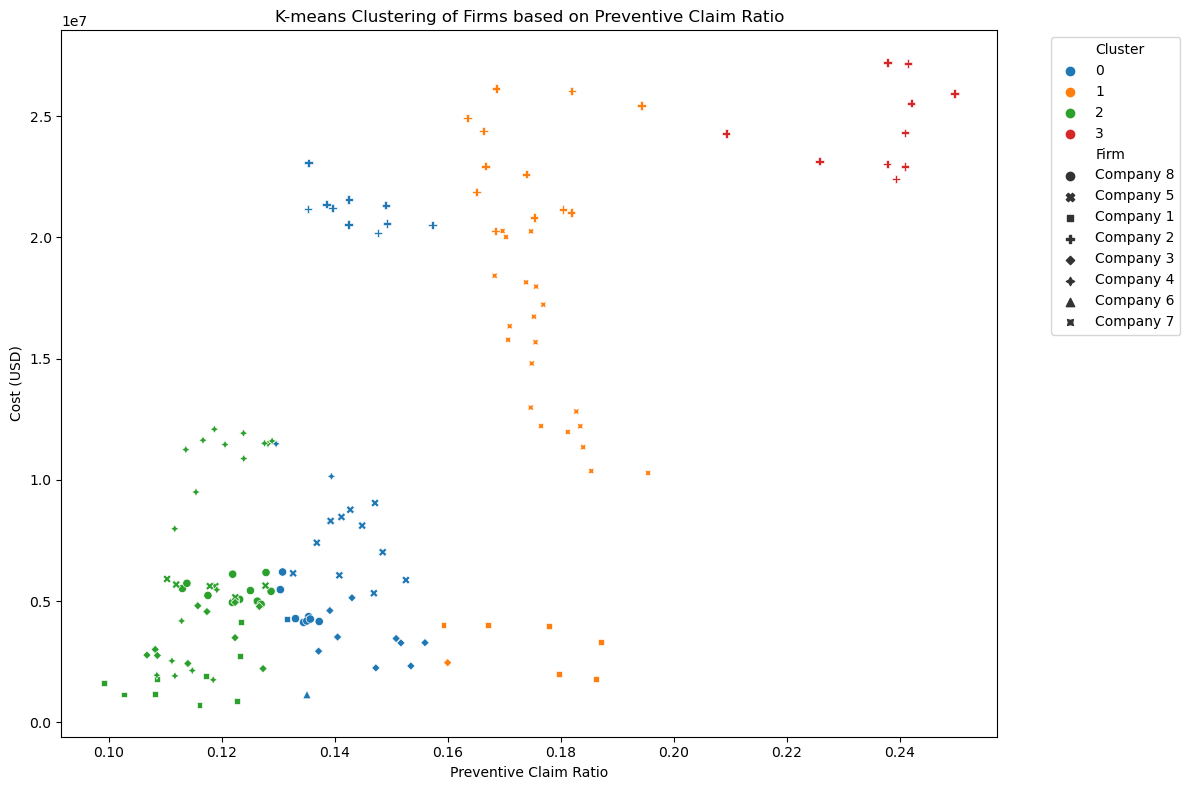

In [37]:
imputer = SimpleImputer(strategy='median')
data_imputed = imputer.fit_transform(all_wellness_df[['Preventive_Claim_Ratio_6_month_avg']])
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_imputed)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
all_wellness_df['Cluster'] = kmeans.fit_predict(data_scaled)

# Evaluate with silhouette score
silhouette_avg = np.round(silhouette_score(data_scaled, all_wellness_df['Cluster']), 2)

print(f'Silhouette Score for k={optimal_k}: {silhouette_avg}')

# Cross-tabulation with actual groups
cross_tab = pd.crosstab(all_wellness_df['Firm'], all_wellness_df['Cluster'])
print(cross_tab)

# Visualize Clusters with Firms
plt.figure(figsize=(12, 8))
sns.scatterplot(data=all_wellness_df, x='Preventive_Claim_Ratio_6_month_avg', y='Amount_Allowed_6_month_avg', hue='Cluster', style='Firm', palette='tab10')
plt.title('K-means Clustering of Firms based on Preventive Claim Ratio')
plt.xlabel('Preventive Claim Ratio')
plt.ylabel('Cost (USD)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## Forecasting Models: ARIMA and SARIMAX

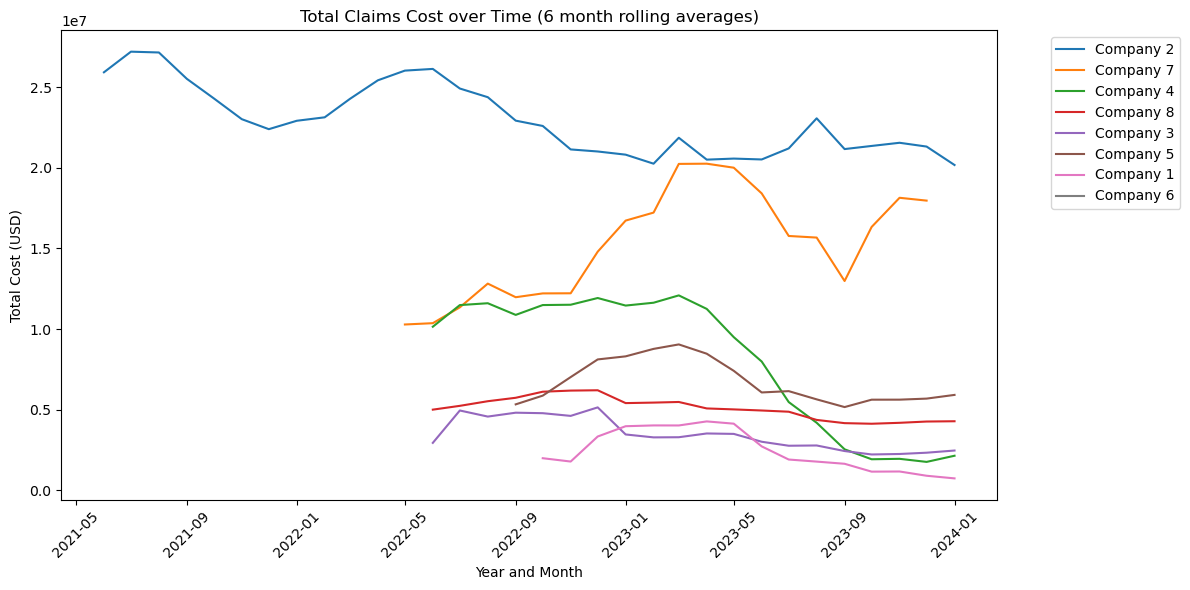

In [38]:
# Visualizing time series data for all clients 
all_wellness_df['Year_Month'] = pd.to_datetime(all_wellness_df['Year_Month'])
all_wellness_df = all_wellness_df.sort_values(by='Year_Month')
plt.figure(figsize=(12, 6))
sns.lineplot(data=all_wellness_df, x='Year_Month', y='Amount_Allowed_6_month_avg', hue='Firm', palette='tab10')
plt.title('Total Claims Cost over Time (6 month rolling averages)')
plt.xlabel('Year and Month')
plt.ylabel('Total Cost (USD)')
plt.legend(bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45)
plt.tight_layout() 
plt.show()

In [39]:
# Select client with most data 
Company2_tsa = all_wellness_df[all_wellness_df['Firm'] == 'Company 2']
relevant_columns = ['Year_Month', 'Preventive_Claim_Ratio_6_month_avg', 'Amount_Allowed_6_month_avg']
Company2_tsa = Company2_tsa[relevant_columns]
Company2_tsa['Year_Month'] = pd.to_datetime(Company2_tsa['Year_Month'])
Company2_tsa = Company2_tsa.sort_values('Year_Month')
Company2_tsa.dropna(inplace=True)

In [40]:
# Split data into train and test sets
train_size = 0.8  # 80% of data for training
train, test = train_test_split(Company2_tsa, train_size=train_size, shuffle=False)

# Reset index for train and test sets
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

# Hyperparameter optimization for ARIMA
best_aic = float('inf')
best_arima_order = None
for p, d, q in itertools.product(range(3), range(2), range(3)):
    try:
        model = ARIMA(train['Amount_Allowed_6_month_avg'], order=(p, d, q), exog=train['Preventive_Claim_Ratio_6_month_avg'])
        results = model.fit()
        aic = results.aic
        if aic < best_aic:
            best_aic = aic
            best_arima_order = (p, d, q)
    except:
        continue

# Hyperparameter optimization for SARIMAX
best_sarimax_aic = float('inf')
best_sarimax_order = None
for p, d, q, P, D, Q in itertools.product(range(3), range(2), range(3), range(3), range(2), range(3)):
    try:
        model = SARIMAX(train['Amount_Allowed_6_month_avg'], order=(p, d, q), seasonal_order=(P, D, Q, 12),
                        exog=train['Preventive_Claim_Ratio_6_month_avg'])
        results = model.fit()
        aic = results.aic
        if aic < best_sarimax_aic:
            best_sarimax_aic = aic
            best_sarimax_order = (p, d, q, P, D, Q)
    except:
        continue

# Train ARIMA model with optimal parameters
arima_model = ARIMA(train['Amount_Allowed_6_month_avg'], order=best_arima_order, exog=train['Preventive_Claim_Ratio_6_month_avg'])
arima_fit = arima_model.fit()

# Train SARIMAX model with optimal parameters
sarimax_model = SARIMAX(train['Amount_Allowed_6_month_avg'], order=(best_sarimax_order[0], best_sarimax_order[1], best_sarimax_order[2]), 
                        seasonal_order=(best_sarimax_order[3], best_sarimax_order[4], best_sarimax_order[5], 12),
                        exog=train['Preventive_Claim_Ratio_6_month_avg'])
sarimax_fit = sarimax_model.fit()

# Model Evaluation
# ARIMA
arima_forecast = arima_fit.forecast(steps=len(test), exog=test['Preventive_Claim_Ratio_6_month_avg'])
arima_rmse = np.sqrt(mean_squared_error(test['Amount_Allowed_6_month_avg'], arima_forecast))
arima_relative_rmse = arima_rmse / np.mean(test['Amount_Allowed_6_month_avg'])

# SARIMAX
sarimax_forecast = sarimax_fit.forecast(steps=len(test), exog=test['Preventive_Claim_Ratio_6_month_avg'])
sarimax_rmse = np.sqrt(mean_squared_error(test['Amount_Allowed_6_month_avg'], sarimax_forecast))
sarimax_relative_rmse = sarimax_rmse / np.mean(test['Amount_Allowed_6_month_avg'])


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76223D+01    |proj g|=  5.43637D-08

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   5.436D-08   1.762D+01
  F =   17.622266470847915     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.6

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.31267D+00    |proj g|=  2.45255D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     34     39      1     0     0   8.734D-06   8.313D+00
  F =   8.3126574355052600     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34805D+00    |proj g|=  8.16421D-01

At iterate    5    f=  8.23854D+00    |proj g|=  2.63237D-03

At iterate   10    f=  8.23854D+00    |proj g|=  9.56267D-04

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65439D+01    |proj g|=  2.44419D-01

At iterate    5    f=  1.64835D+01    |proj g|=  3.65432D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   3.654D-06   1.648D+01
  F =   16.483497200889275     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  8.24938D+00    |proj g|=  4.21025D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   2.042D-06   8.249D+00
  F =   8.2493767954698978     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34455D+00    |proj g|=  7.61993D-01

At iterate    5    f=  8.24569D+00    |proj g|=  3.04977D-01

At iterate   10    f=  8.24310D+00    |proj g|=  7.57325D-05

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     11      1     0     0   4.225D-06   1.616D+01
  F =   16.155183345738280     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64955D+01    |proj g|=  9.58109D-01

At iterate    5    f=  1.61550D+01    |proj g|=  7.84593D-03

At iterate   10    f=  1.61546D+01    |proj g|=  1.43473D-05

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.64953D+01    |proj g|=  9.55925D-01

At iterate    5    f=  1.61556D+01    |proj g|=  7.00289D-03

At iterate   10    f=  1.61552D+01    |proj g|=  1.71134D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     11      1     0     0   1.711D-06   1.616D+01
  F =   16.155183345187865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     38      1     0     0   3.161D-04   8.136D+00
  F =   8.1363063773533426     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65451D+01    |proj g|=  9.38460D-01

At iterate    5    f=  1.61571D+01    |proj g|=  2.59595D-02

At iterate   10    f=  1.61546D+01    |proj g|=  1.22538D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.61546D+01    |proj g|=  3.06024D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     10     11      1     0     0   3.060D-05   1.615D+01
  F =   16.154586621704038     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34410D+00    |proj g|=  9.32188D-01

At iterate    5    f=  8.13572D+00    |proj g|=  2.84272D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.34410D+00    |proj g|=  9.32188D-01

At iterate    5    f=  8.13708D+00    |proj g|=  4.61295D-02

At iterate   10    f=  8.13589D+00    |proj g|=  2.37678D-03

At iterate   15    f=  8.13575D+00    |proj g|=  8.98505D-03

At iterate   20    f=  8.13573D+00    |proj g|=  7.05790D-04

At iterate   25    f=  8.13572D+00    |proj g|=  3.74244D-03

At iterate   30    f=  8.13571D+00    |proj g|=  1.12402D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   6.262D-06   1.602D+01
  F =   16.018675426293747     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38460D+00    |proj g|=  1.37973D+00

At iterate    5    f=  8.20709D+00    |proj g|=  1.58060D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65146D+01    |proj g|=  1.14628D+00

At iterate    5    f=  1.60188D+01    |proj g|=  1.11142D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     10      1     0     0   3.791D-07   1.602D+01
  F =   16.018783189863921     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 v

 This problem is unconstrained.



At iterate   10    f=  8.05312D+00    |proj g|=  1.74146D-03

At iterate   15    f=  8.05304D+00    |proj g|=  7.27857D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     18     21      1     0     0   1.645D-03   8.053D+00
  F =   8.0530162450880489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65608D+01    |proj g|=  1.12534D+00

At iterate    5    f=  1.60187D+01    |proj g|=  2.92939D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.60187D+01    |proj g|=  5.35552D-03

At iterate   10    f=  1.60187D+01    |proj g|=  3.07914D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     10     12      1     0     0   3.079D-06   1.602D+01
  F =   16.018675391723445     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.65149D+01    |proj g|=  1.14890D+00

At iterate    5    f=  1.60187D+01    |proj g|=  3.41014D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     14      1     0     0   2.871D-06   8.052D+00
  F =   8.0523069761479729     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.38460D+00    |proj g|=  1.37973D+00

At iterate    5    f=  8.06048D+00    |proj g|=  1.77438D-01

At iterate   10    f=  8.05234D+00    |proj g|=  1.08544D-02

At iterate   15    f=  8.05232D+00    |proj g|=  1.50960D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  8.05231D+00    |proj g|=  2.58714D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     23     38      1     0     0   3.161D-04   8.052D+00
  F =   8.0523110031562410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56053D+01    |proj g|=  2.05000D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      3     20      1     0     0   6.375D-05   1.455D+01
  F =   14.553950610528837     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.73207D+00    |proj g|=  1.15995D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45511D+01    |proj g|=  1.69453D-01

At iterate   10    f=  1.45491D+01    |proj g|=  3.61432D-02

At iterate   15    f=  1.45488D+01    |proj g|=  1.26190D-02

At iterate   20    f=  1.45488D+01    |proj g|=  2.06265D-03

At iterate   25    f=  1.45487D+01    |proj g|=  1.68310D-03

At iterate   30    f=  1.45486D+01    |proj g|=  6.16269D-04

At iterate   35    f=  1.45484D+01    |proj g|=  3.46880D-04

At iterate   40    f=  1.45479D+01    |proj g|=  2.38943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     43     50      1     0     0   8.419D-06   1.455D+01
  F =   14.5477998213

 This problem is unconstrained.



At iterate   20    f=  7.31331D+00    |proj g|=  3.47921D-02

At iterate   25    f=  7.31302D+00    |proj g|=  1.14222D-02

At iterate   30    f=  7.31292D+00    |proj g|=  1.29090D-02

At iterate   35    f=  7.31283D+00    |proj g|=  3.85339D-03

At iterate   40    f=  7.31282D+00    |proj g|=  5.76812D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     77      2     0     0   6.148D-05   7.313D+00
  F =   7.3128184786537727     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.45491D+01    |proj g|=  5.83661D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f=  7.31197D+00    |proj g|=  3.28581D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     38      1     0     0   3.286D-03   7.312D+00
  F =   7.3119664017975348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36241D+00    |proj g|=  4.14292D-01

At iterate    5    f=  7.31101D+00    |proj g|=  3.25805D-01

At iterate   10    f=  7.31005D+00    |proj g|=  8.84278D-03

At iter

 This problem is unconstrained.



At iterate   20    f=  7.30808D+00    |proj g|=  2.46875D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     35      1     0     0   5.859D-03   7.308D+00
  F =   7.3080439242896862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48890D+01    |proj g|=  6.59452D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29636D+00    |proj g|=  1.58276D+01

At iterate    5    f=  7.25724D+00    |proj g|=  1.04023D-01

At iterate   10    f=  7.24637D+00    |proj g|=  6.80326D-02

At iterate   15    f=  7.24468D+00    |proj g|=  1.81274D-02

At iterate   20    f=  7.24463D+00    |proj g|=  4.71071D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     44      2     0     0   4.711D-05   7.245D+00
  F =   7.2446267372435962     

CONVERG


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83944D+01    |proj g|=  1.74229D+01

At iterate    5    f=  1.45166D+01    |proj g|=  9.21752D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   9.218D-07   1.452D+01
  F =   14.516579021788647     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.26179D+00    |proj g|=  1.10652D-01

At iterate   15    f=  7.25954D+00    |proj g|=  3.15721D-02

At iterate   20    f=  7.25626D+00    |proj g|=  1.28227D-01

At iterate   25    f=  7.25554D+00    |proj g|=  1.95435D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     37      1     0     0   1.464D-05   7.256D+00
  F =   7.2555311963812947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   15    f=  7.24414D+00    |proj g|=  2.40585D-03

At iterate   20    f=  7.24414D+00    |proj g|=  9.16790D-03

At iterate   25    f=  7.24393D+00    |proj g|=  8.44452D-03

At iterate   30    f=  7.24389D+00    |proj g|=  1.30352D-02

At iterate   35    f=  7.24387D+00    |proj g|=  4.03723D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     51      1     0     0   4.037D-04   7.244D+00
  F =   7.2438725004352742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45143D+01    |proj g|=  3.14503D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      5     43      2     0     0   3.145D-04   1.451D+01
  F =   14.514335908761153     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.48890D+01    |proj g|=  6.59452D+00

At iterate    5    f=  1.45143D+01    |proj g|=  3.81433D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   25    f=  7.24344D+00    |proj g|=  6.72072D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     46      1     0     0   6.721D-03   7.243D+00
  F =   7.2434352073957813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29636D+00    |proj g|=  1.58276D+01

At iterate    5    f=  7.25395D+00    |proj g|=  7.08502D-02

At iterate   10    f=  7.24372D+00    |proj g|=  5.62273D-02

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  7.24355D+00    |proj g|=  2.78587D-02

At iterate   25    f=  7.24345D+00    |proj g|=  7.52479D-03

At iterate   30    f=  7.24345D+00    |proj g|=  8.80901D-04

At iterate   35    f=  7.24343D+00    |proj g|=  9.31592D-03



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     61      1     0     0   8.981D-04   7.243D+00
  F =   7.2434277224731201     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91463D+01    |proj g|=  1.46102D+01

At iterate    5    f=  1.45212D+01    |proj g|=  2.86018D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


At iterate    5    f=  1.45194D+01    |proj g|=  1.70300D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   2.230D-05   1.452D+01
  F =   14.519438906395754     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91463D+01    |proj g|=  1.46102D+01

At iterate    5    f=  1.45195D+01    |proj g|=  7.34741D-02

At iterate   10    f=  1.45194D+01    |proj g|=  1.88088D-02

At itera

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45169D+01    |proj g|=  7.20073D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      7     10      1     0     0   5.253D-04   1.452D+01
  F =   14.516888646695147     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iterate    5    f=  7.27872D+00    |proj g|=  1.70222D-02

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     37      1     0     0   7.207D-05   7.273D+00
  F =   7.2730812913997713     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iterate    5    f=  7.26103D+00    |proj g|=  6.81778D-02

At iterate   10    f=  7.26073D+00    |proj g|=  5.47343D-02

At iterate   15    f=  7.26041D+00    |proj g|=  3.47701D-03

At iter

 This problem is unconstrained.



At iterate   30    f=  7.25962D+00    |proj g|=  1.32696D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     47      1     0     0   1.327D-04   7.260D+00
  F =   7.2596211229236847     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91463D+01    |proj g|=  1.46102D+01

At iterate    5    f=  1.45169D+01    |proj g|=  2.79909D-03

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45169D+01    |proj g|=  4.61981D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      8     17      1     0     0   4.280D-04   1.452D+01
  F =   14.516888647328489     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iterate    5    f=  7.26441D+00    |proj g|=  5.33824D-02

At iterate   10    f=  7.25962D+00    |proj g|=  1.62625D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iterate    5    f=  7.26029D+00    |proj g|=  1.69020D-01

At iterate   10    f=  7.25907D+00    |proj g|=  5.13289D-02

At iterate   15    f=  7.25890D+00    |proj g|=  4.12832D-03

At iterate   20    f=  7.25869D+00    |proj g|=  3.49877D-02

At iterate   25    f=  7.25861D+00    |proj g|=  4.02845D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     50      2     0     0   1.238D-04   7.259D+00
  F =   7.2586086735647291     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.34750D+01    |proj g|=  1.97451D+01

At iterate    5    f=  7.25965D+00    |proj g|=  1.03605D-01

At iterate   10    f=  7.25939D+00    |proj g|=  1.80020D-02

At iterate   15    f=  7.25917D+00    |proj g|=  1.90818D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07117D+01    |proj g|=  1.33648D+00

At iterate    5    f=  8.82299D+00    |proj g|=  1.96738D-01

At iterate   10    f=  8.74729D+00    |proj g|=  2.39910D-02

At iterate   15    f=  8.73560D+00    |proj g|=  2.99736D-03

At iterate   20    f=  8.73385D+00    |proj g|=  7.97273D-04

At iterate   25    f=  8.73360D+00    |proj g|=  9.47763D-05

At iterate   30    f=  8.73357D+00    |proj g|=  8.93202D-04

At iterate   35    f=  8.73356D+00    |proj g|=  1.73610D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate   15    f=  8.07382D+00    |proj g|=  2.14529D-01

At iterate   20    f=  7.99940D+00    |proj g|=  5.35764D-01

At iterate   25    f=  7.96004D+00    |proj g|=  6.16998D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     47      1     0     0   6.630D-06   7.960D+00
  F =   7.9600366518292480     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56869D+01    |proj g|=  2.22066D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.56461D+01    |proj g|=  4.87728D-04

At iterate   15    f=  1.56460D+01    |proj g|=  6.32918D-03

At iterate   20    f=  1.56458D+01    |proj g|=  1.96879D-03

At iterate   25    f=  1.56457D+01    |proj g|=  1.59442D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     35      1     0     0   4.745D-06   1.565D+01
  F =   15.645738623752665     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.51140D+00    |proj g|=  1.48049D+00

At iterate   10    f=  8.07910D+00    |proj g|=  1.28662D-01

At iterate   15    f=  8.07681D+00    |proj g|=  2.29316D-03

At iterate   20    f=  8.07619D+00    |proj g|=  1.92527D-02

At iterate   25    f=  8.07570D+00    |proj g|=  1.39680D-03

At iterate   30    f=  8.07563D+00    |proj g|=  1.07240D-03

At iterate   35    f=  8.07561D+00    |proj g|=  4.55946D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     39     47      1     0     0   7.763D-06   8.076D+00
  F =   8.0756132101072815     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

 This problem is unconstrained.



At iterate   10    f=  8.14528D+00    |proj g|=  2.92667D-02

At iterate   15    f=  8.01271D+00    |proj g|=  5.78129D-01

At iterate   20    f=  7.96973D+00    |proj g|=  2.38567D-02

At iterate   25    f=  7.96800D+00    |proj g|=  1.10397D-01

At iterate   30    f=  7.96379D+00    |proj g|=  3.16144D-02

At iterate   35    f=  7.96135D+00    |proj g|=  2.18842D-02

At iterate   40    f=  7.96047D+00    |proj g|=  3.56292D-02

At iterate   45    f=  7.95988D+00    |proj g|=  2.48000D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     95      2     0     0   1.157D-04   7.960D+00
  F =   7.9598746564642884     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.56521D+01    |proj g|=  7.89740D-02

At iterate    5    f=  1.56455D+01    |proj g|=  9.48699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments 

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.56458D+01    |proj g|=  4.55733D-03

At iterate   10    f=  1.56454D+01    |proj g|=  5.97080D-04

At iterate   15    f=  1.56454D+01    |proj g|=  3.11246D-03

At iterate   20    f=  1.56453D+01    |proj g|=  1.07309D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     26      1     0     0   1.241D-05   1.565D+01
  F =   15.645274637166443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   25    f=  8.64075D+00    |proj g|=  6.89269D-05

At iterate   30    f=  8.64071D+00    |proj g|=  2.31006D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     48      1     0     0   1.791D-04   8.641D+00
  F =   8.6407079973329228     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07117D+01    |proj g|=  1.33648D+00


 This problem is unconstrained.



At iterate    5    f=  8.66070D+00    |proj g|=  8.48116D-02

At iterate   10    f=  8.60157D+00    |proj g|=  3.75999D-02

At iterate   15    f=  8.58245D+00    |proj g|=  6.97631D-03

At iterate   20    f=  8.57982D+00    |proj g|=  9.03878D-04

At iterate   25    f=  8.57913D+00    |proj g|=  5.28990D-04

At iterate   30    f=  8.57902D+00    |proj g|=  2.81395D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     54      1     0     0   4.046D-04   8.579D+00
  F =   8.5790062484469782     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  8.27680D+00    |proj g|=  8.63678D-02

At iterate   10    f=  8.25776D+00    |proj g|=  1.22587D-01

At iterate   15    f=  8.23172D+00    |proj g|=  8.70496D-01

At iterate   20    f=  8.17423D+00    |proj g|=  2.65197D-01

At iterate   25    f=  8.16681D+00    |proj g|=  1.32913D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     49      1     0     0   1.329D-04   8.167D+00
  F =   8.1668111324457673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  7.92424D+00    |proj g|=  1.71697D-01

At iterate   15    f=  7.91619D+00    |proj g|=  5.11490D-01

At iterate   20    f=  7.86738D+00    |proj g|=  3.78860D-01

At iterate   25    f=  7.85213D+00    |proj g|=  6.70422D-02

At iterate   30    f=  7.85167D+00    |proj g|=  5.80974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     40      1     0     0   7.171D-05   7.852D+00
  F =   7.8516667594150178     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.55028D+01    |proj g|=  8.72272D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   2.052D-05   1.550D+01
  F =   15.502823799974372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55228D+01    |proj g|=  5.81888D-02

At iterate    5    f=  1.55019D+01    |proj g|=  5.35785D-03

At iterate   10    f=  1.54998D+01    |proj g|=  1.34609D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.28773D+00    |proj g|=  7.36316D-02

At iterate   10    f=  8.27558D+00    |proj g|=  9.01594D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     16      1     0     0   1.198D-05   8.275D+00
  F =   8.2753669353978072     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22078D+00    |proj g|=  5.62423D+00

At iterate    5    f=  8.28039D+00    |proj g|=  8.55592D-02

At iter

 This problem is unconstrained.



At iterate   25    f=  7.85280D+00    |proj g|=  2.38118D-01

At iterate   30    f=  7.84280D+00    |proj g|=  4.39883D-02

At iterate   35    f=  7.84183D+00    |proj g|=  1.19254D-02

At iterate   40    f=  7.83994D+00    |proj g|=  3.45157D-02

At iterate   45    f=  7.83844D+00    |proj g|=  7.89976D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     60      1     0     0   1.324D-04   7.838D+00
  F =   7.8384109552894961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55351D+01    |proj g|=  1.45491D-01

At iterate    5    f=  1.54971D+01    |proj g|=  2.41955D-03

At iterate   10    f=  1.54970D+01    |proj g|=  5.35181D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   5.352D-06   1.550D+01
  F =   15.497031517444427     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.



At iterate   15    f=  7.91831D+00    |proj g|=  1.36940D-01

At iterate   20    f=  7.89133D+00    |proj g|=  5.40671D-01

At iterate   25    f=  7.84265D+00    |proj g|=  5.59783D-01

At iterate   30    f=  7.82963D+00    |proj g|=  3.67907D-02

At iterate   35    f=  7.82850D+00    |proj g|=  1.95618D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     46      1     0     0   1.701D-06   7.829D+00
  F =   7.8285038661422224     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

 This problem is unconstrained.



At iterate   25    f=  7.84555D+00    |proj g|=  1.18398D-01

At iterate   30    f=  7.83010D+00    |proj g|=  1.75325D-01

At iterate   35    f=  7.82882D+00    |proj g|=  4.33184D-03

At iterate   40    f=  7.82864D+00    |proj g|=  1.27542D-02

At iterate   45    f=  7.82831D+00    |proj g|=  1.55012D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     56      1     0     0   1.550D-03   7.828D+00
  F =   7.8283146473489458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *


 This problem is unconstrained.



Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.22078D+00    |proj g|=  5.62423D+00

At iterate    5    f=  7.95817D+00    |proj g|=  2.07697D-01

At iterate   10    f=  7.93925D+00    |proj g|=  2.88292D-01

At iterate   15    f=  7.91883D+00    |proj g|=  7.05566D-02

At iterate   20    f=  7.89273D+00    |proj g|=  4.15948D-01

At iterate   25    f=  7.84592D+00    |proj g|=  3.38517D-01

At iterate   30    f=  7.83378D+00    |proj g|=  9.23271D-02

At iterate   35    f=  7.83183D+00    |proj g|=  6.89562D-02

At iterate   40    f=  7.83025D+00    |proj g|=  8.55671D-02

At iterate   45    f=  7.82841D+00    |proj g|=  5.20896D-02

At iterate   50    f=  7.82829D+00    |proj g|=  4.56366D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates 

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.54510D+01    |proj g|=  1.41161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     13     19      1     0     0   2.122D-06   1.545D+01
  F =   15.451018649994262     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73698D+00    |proj g|=  3.16538D+00

At iterate    5    f=  8.33163D+00    |proj g|=  4.76782D-02

At iterate   10    f=  8.32967D+00    |proj g|=  1.17671D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   20    f=  8.10650D+00    |proj g|=  8.13886D-02

At iterate   25    f=  8.10571D+00    |proj g|=  8.80441D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     51      1     0     0   8.804D-05   8.106D+00
  F =   8.1057145280574314     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73698D+00    |proj g|=  3.16538D+00

At iterate    5    f=  7.95070D+00    |proj g|=  4.82876D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  7.88347D+00    |proj g|=  1.06944D+00

At iterate   20    f=  7.84884D+00    |proj g|=  1.77980D-01

At iterate   25    f=  7.84230D+00    |proj g|=  8.33546D-02

At iterate   30    f=  7.84182D+00    |proj g|=  2.95819D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     37      1     0     0   1.048D-04   7.842D+00
  F =   7.8418152053285128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     18      1     0     0   4.296D-06   1.545D+01
  F =   15.451372419421752     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.55141D+01    |proj g|=  2.61925D-01

At iterate    5    f=  1.54524D+01    |proj g|=  1.67586D-02

At iterate   10    f=  1.54515D+01    |proj g|=  2.76390D-03

At iterate   15    f=  1.54513D+01    |proj g|=  8.68209D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.22130D+00    |proj g|=  9.90385D-02

At iterate   10    f=  8.17200D+00    |proj g|=  4.97652D-01

At iterate   15    f=  8.09594D+00    |proj g|=  2.43781D-01

At iterate   20    f=  7.94923D+00    |proj g|=  3.12135D-01

At iterate   25    f=  7.92679D+00    |proj g|=  2.64296D-02

At iterate   30    f=  7.92535D+00    |proj g|=  1.19951D-02

At iterate   35    f=  7.92467D+00    |proj g|=  1.18236D-01

At iterate   40    f=  7.92403D+00    |proj g|=  1.28975D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     50      1     0     0   2.305D-05   7.924D+00
  F =   7.92402711375

 This problem is unconstrained.



At iterate   20    f=  7.86705D+00    |proj g|=  3.16582D-01

At iterate   25    f=  7.84384D+00    |proj g|=  7.63964D-02

At iterate   30    f=  7.83650D+00    |proj g|=  9.96951D-02

At iterate   35    f=  7.83577D+00    |proj g|=  2.69006D-02

At iterate   40    f=  7.83485D+00    |proj g|=  2.53542D-02

At iterate   45    f=  7.83328D+00    |proj g|=  2.60001D-02

At iterate   50    f=  7.83308D+00    |proj g|=  6.19123D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     58      1     0     0   6.191D-04   7.833D+00
  F =   7.8330845047560089     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54526D+01    |proj g|=  2.14885D-02

At iterate   10    f=  1.54511D+01    |proj g|=  2.65897D-03

At iterate   15    f=  1.54511D+01    |proj g|=  6.53263D-04

At iterate   20    f=  1.54510D+01    |proj g|=  1.29429D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     32      1     0     0   9.616D-06   1.545D+01
  F =   15.451018856477054     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  1.54524D+01    |proj g|=  1.73575D-02

At iterate   10    f=  1.54510D+01    |proj g|=  1.99798D-03

At iterate   15    f=  1.54510D+01    |proj g|=  1.21163D-03

At iterate   20    f=  1.54510D+01    |proj g|=  1.44749D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     22     28      1     0     0   2.684D-05   1.545D+01
  F =   15.451003848524349     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  7.94623D+00    |proj g|=  1.41802D-01

At iterate   15    f=  7.88168D+00    |proj g|=  4.53651D-01

At iterate   20    f=  7.84534D+00    |proj g|=  4.62274D-01

At iterate   25    f=  7.82805D+00    |proj g|=  1.06943D-01

At iterate   30    f=  7.82707D+00    |proj g|=  3.44202D-03



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     34     71      2     0     0   9.604D-05   7.827D+00
  F =   7.8270637199188435     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  8.73698D+00    |proj g|=  3.16538D+00

At iterate    5    f=  7.95095D+00    |proj g|=  1.37132D-01

At iterate   10    f=  7.94721D+00    |proj g|=  1.16907D-01

At iterate   15    f=  7.90111D+00    |proj g|=  8.92744D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.95100D+00    |proj g|=  1.20959D-01

At iterate   10    f=  7.94918D+00    |proj g|=  4.26867D-02

At iterate   15    f=  7.91109D+00    |proj g|=  2.14231D-01

At iterate   20    f=  7.85632D+00    |proj g|=  2.75178D-01

At iterate   25    f=  7.83307D+00    |proj g|=  2.96908D-01

At iterate   30    f=  7.82787D+00    |proj g|=  1.44660D-02

At iterate   35    f=  7.82709D+00    |proj g|=  1.24149D-02

At iterate   40    f=  7.82672D+00    |proj g|=  2.09729D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     52      1     0     0   8.910D-04   7.827D+00
  F =   7.82671058872

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.25781D+00    |proj g|=  6.59982D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5     26      1     0     0   6.600D-05   7.258D+00
  F =   7.2578144508661593     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47084D+00    |proj g|=  5.20991D+00

At iterate    5    f=  7.25285D+00    |proj g|=  3.61202D-01

At iterate   10    f=  7.23891D+00    |proj g|=  2.29776D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.83934D+01    |proj g|=  1.62107D+01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   5.164D-05   1.452D+01
  F =   14.516082511605200     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.5

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.24363D+00    |proj g|=  6.82106D-01

At iterate   10    f=  7.23511D+00    |proj g|=  2.74013D-02

At iterate   15    f=  7.23509D+00    |proj g|=  6.74842D-03

At iterate   20    f=  7.23494D+00    |proj g|=  4.61029D-02

At iterate   25    f=  7.23471D+00    |proj g|=  3.51694D-03

At iterate   30    f=  7.23471D+00    |proj g|=  1.49950D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     48      1     0     0   1.499D-03   7.235D+00
  F =   7.2347098015988589     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.25319D+00    |proj g|=  5.06573D-01

At iterate   10    f=  7.23469D+00    |proj g|=  1.23370D-01

At iterate   15    f=  7.23406D+00    |proj g|=  7.73613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     30      1     0     0   7.736D-04   7.234D+00
  F =   7.2340593766928771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.47084D+00    |proj g|=  5.20991D+00



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  7.23843D+00    |proj g|=  3.05798D-01

At iterate   10    f=  7.23417D+00    |proj g|=  2.19767D-03

At iterate   15    f=  7.23416D+00    |proj g|=  2.80044D-03

At iterate   20    f=  7.23407D+00    |proj g|=  3.20235D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     47      1     0     0   2.589D-03   7.234D+00
  F =   7.2340707904187012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  7.23413D+00    |proj g|=  1.95225D-02

At iterate   25    f=  7.23407D+00    |proj g|=  1.66827D-03

At iterate   30    f=  7.23407D+00    |proj g|=  1.32844D-03

At iterate   35    f=  7.23407D+00    |proj g|=  1.42691D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     53      1     0     0   1.468D-02   7.234D+00
  F =   7.2340651209931925     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.45373D+01    |proj g|=  9.64875D-01

At iterate   15    f=  1.45162D+01    |proj g|=  6.64587D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     44      1     0     0   3.394D-03   1.452D+01
  F =   14.516045793377339     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.26357D+00    |proj g|=  1.32939D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.26005D+00    |proj g|=  1.94737D-01

At iterate   15    f=  7.25968D+00    |proj g|=  2.14677D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     27      1     0     0   2.147D-04   7.260D+00
  F =   7.2596824627020897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.25922D+00    |proj g|=  4.00182D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45410D+01    |proj g|=  4.14561D-01

At iterate   10    f=  1.45179D+01    |proj g|=  1.31177D-01

At iterate   15    f=  1.45176D+01    |proj g|=  3.59068D-02

At iterate   20    f=  1.45168D+01    |proj g|=  1.45944D-01

At iterate   25    f=  1.45162D+01    |proj g|=  1.83396D-02

At iterate   30    f=  1.45161D+01    |proj g|=  1.69405D-02

At iterate   35    f=  1.45161D+01    |proj g|=  1.12664D-02

At iterate   40    f=  1.45161D+01    |proj g|=  4.44971D-03

At iterate   45    f=  1.45160D+01    |proj g|=  4.69510D-03

At iterate   50    f=  1.45160D+01    |proj g|=  7.83220D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate    5    f=  1.45407D+01    |proj g|=  3.42050D-02

At iterate   10    f=  1.45320D+01    |proj g|=  1.17592D+00

At iterate   15    f=  1.45160D+01    |proj g|=  2.65433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     15     39      1     0     0   2.654D-03   1.452D+01
  F =   14.516046021930897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iter

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  7.26005D+00    |proj g|=  2.00382D-01

At iterate   15    f=  7.25969D+00    |proj g|=  2.41619D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     28      1     0     0   2.416D-04   7.260D+00
  F =   7.2596908574276950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.26261D+00    |proj g|=  5.38105D-02

At iter

 This problem is unconstrained.



At iterate   10    f=  7.24232D+00    |proj g|=  8.17834D-02

At iterate   15    f=  7.24049D+00    |proj g|=  1.41348D-01

At iterate   20    f=  7.23436D+00    |proj g|=  2.89260D-02

At iterate   25    f=  7.23411D+00    |proj g|=  2.42446D-02

At iterate   30    f=  7.23382D+00    |proj g|=  1.12550D-02

At iterate   35    f=  7.23380D+00    |proj g|=  1.56427D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     53      1     0     0   1.564D-03   7.234D+00
  F =   7.2338037147871042     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.45375D+01    |proj g|=  9.08827D-01

At iterate   15    f=  1.45167D+01    |proj g|=  1.70521D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     27      1     0     0   4.146D-04   1.452D+01
  F =   14.516046290123873     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53779D+01    |proj g|=  8.08642D+00

At iterate    5    f=  1.45408D+01    |proj g|=  7.77206D-03

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     17     36      1     0     0   5.561D-04   1.452D+01
  F =   14.516045997055521     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.25844D+00    |proj g|=  4.45799D-01

At iterate   10    f=  7.24047D+00    |proj g|=  3.18574D-02

At iterate   15    f=  7.23844D+00    |proj g|=  3.47290D-01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   25    f=  7.23255D+00    |proj g|=  1.06109D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     39      1     0     0   1.061D-04   7.233D+00
  F =   7.2325506347245936     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.26054D+00    |proj g|=  3.10711D-01

At iterate   10    f=  7.24162D+00    |proj g|=  1.02176D-01

At iter

 This problem is unconstrained.



At iterate   25    f=  7.23265D+00    |proj g|=  3.91063D-02

At iterate   30    f=  7.23257D+00    |proj g|=  2.40113D-02

At iterate   35    f=  7.23256D+00    |proj g|=  6.92433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     55      1     0     0   1.593D-03   7.233D+00
  F =   7.2325546978294515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36127D+00    |proj g|=  3.34834D+00

At iterate    5    f=  7.25987D+00    |proj g|=  3.52205D-01

At iterate   10    f=  7.24268D+00    |proj g|=  3.87494D-02

At iterate   15    f=  7.23347D+00    |proj g|=  1.27927D-02

At iterate   20    f=  7.23336D+00    |proj g|=  3.90248D-02

At iterate   25    f=  7.23256D+00    |proj g|=  2.74431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     34      1     0     0   

 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.45150D+01    |proj g|=  1.86078D-01

At iterate   15    f=  1.45075D+01    |proj g|=  4.02984D-01

At iterate   20    f=  1.45051D+01    |proj g|=  2.98709D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     37      1     0     0   2.987D-03   1.451D+01
  F =   14.505080122038699     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90083D+01    |proj g|=  1.46367D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     38      1     0     0   3.072D-03   1.450D+01
  F =   14.502579248864841     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27609D+00    |proj g|=  1.47235D-03

At iterate   10    f=  7.27608D+00    |proj g|=  2.14002D-02

At iterate   15    f=  7.27604D+00    |proj g|=  5.41334D-05

       


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   30    f=  7.25606D+00    |proj g|=  5.09177D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     34      1     0     0   5.703D-05   7.256D+00
  F =   7.2560630362542131     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.25960D+01    |proj g|=  1.75437D+01

At iterate    5    f=  1.45154D+01    |proj g|=  2.29090D-02

At iterate   10    f=  1.45137D+01    |proj g|=  3.01752D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.45048D+01    |proj g|=  3.14905D-03

At iterate   25    f=  1.45048D+01    |proj g|=  4.09006D-02

At iterate   30    f=  1.45037D+01    |proj g|=  1.44029D-01

At iterate   35    f=  1.45028D+01    |proj g|=  1.32113D-02

At iterate   40    f=  1.45027D+01    |proj g|=  3.44084D-02

At iterate   45    f=  1.45026D+01    |proj g|=  1.11051D-02

At iterate   50    f=  1.45026D+01    |proj g|=  5.91374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     58      1     0     0   5.914D-03   1.450D+01
  F =   14.502599041435861     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.45125D+01    |proj g|=  1.70159D-01

At iterate   15    f=  1.45047D+01    |proj g|=  3.46904D-01

At iterate   20    f=  1.45026D+01    |proj g|=  5.05174D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     21     24      1     0     0   3.545D-04   1.450D+01
  F =   14.502579413873823     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  7.25536D+00    |proj g|=  8.53494D-02

At iterate   15    f=  7.25519D+00    |proj g|=  1.58287D-02

At iterate   20    f=  7.25484D+00    |proj g|=  9.04306D-03

At iterate   25    f=  7.25482D+00    |proj g|=  4.51452D-03

At iterate   30    f=  7.25462D+00    |proj g|=  1.52434D-02

At iterate   35    f=  7.25449D+00    |proj g|=  1.65189D-02

At iterate   40    f=  7.25447D+00    |proj g|=  1.82446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     44      1     0     0   1.464D-04   7.254D+00
  F =   7.2544717901991342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.45026D+01    |proj g|=  4.15898D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     28      1     0     0   3.720D-03   1.450D+01
  F =   14.502579306411953     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.90083D+01    |proj g|=  1.46367D+01

At iterate    5    f=  1.45129D+01    |proj g|=  3.35028D-02

At iterate   10    f=  1.45125D+01    |proj g|=  1.77048D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  1.45067D+01    |proj g|=  4.45181D-01

At iterate   20    f=  1.45026D+01    |proj g|=  3.63617D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     26      1     0     0   2.905D-03   1.450D+01
  F =   14.502579267433026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27347D+00    |proj g|=  1.87487D-01

At iter

 This problem is unconstrained.



At iterate   15    f=  7.25340D+00    |proj g|=  2.32827D-03

At iterate   20    f=  7.25333D+00    |proj g|=  8.40573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     28      1     0     0   7.984D-04   7.253D+00
  F =   7.2533194049356124     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00

At iterate    5    f=  7.27328D+00    |proj g|=  1.54904D-01


 This problem is unconstrained.



At iterate   10    f=  7.25380D+00    |proj g|=  7.53895D-02

At iterate   15    f=  7.25361D+00    |proj g|=  5.77376D-03

At iterate   20    f=  7.25347D+00    |proj g|=  3.90693D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     24     28      1     0     0   3.192D-03   7.253D+00
  F =   7.2534059950708265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35583D+00    |proj g|=  2.62987D+00


 This problem is unconstrained.



At iterate    5    f=  7.27351D+00    |proj g|=  1.64466D-01

At iterate   10    f=  7.25485D+00    |proj g|=  1.49253D-01

At iterate   15    f=  7.25416D+00    |proj g|=  7.32449D-03

At iterate   20    f=  7.25395D+00    |proj g|=  7.63931D-02

At iterate   25    f=  7.25352D+00    |proj g|=  1.38759D-02

At iterate   30    f=  7.25338D+00    |proj g|=  1.59179D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     33     46      1     0     0   1.408D-03   7.253D+00
  F =   7.2533705881232438     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53991D+01    |proj g|=  3.35717D-02

At iterate    5    f=  1.53968D+01    |proj g|=  1.25215D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   1.252D-06   1.540D+01
  F =   15.396771959117256     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 v

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08664D+00    |proj g|=  4.56276D+00

At iterate    5    f=  7.92919D+00    |proj g|=  6.23555D-02

At iterate   10    f=  7.92812D+00    |proj g|=  1.84521D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     13     15      1     0     0   2.021D-06   7.928D+00
  F =   7.9281169890343355     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  8.35331D+00    |proj g|=  3.28324D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     12      1     0     0   2.247D-05   8.346D+00
  F =   8.3456376980432978     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.08664D+00    |proj g|=  4.56276D+00

At iterate    5    f=  8.36904D+00    |proj g|=  6.53444D-01

At iterate   10    f=  8.28692D+00    |proj g|=  7.23568D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.53912D+01    |proj g|=  2.65850D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6      9     11      1     0     0   3.996D-06   1.539D+01
  F =   15.391096748561178     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.53991D+01    |proj g|=  3.35717D-02

At iterate    5    f=  1.53911D+01    |proj g|=  6.17906D-03

At iterate   10    f=  1.53909D+01    |proj g|=  7.45418D-03

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.53912D+01    |proj g|=  4.06766D-03

At iterate   10    f=  1.53909D+01    |proj g|=  3.49495D-03

At iterate   15    f=  1.53904D+01    |proj g|=  8.67749D-04

At iterate   20    f=  1.53904D+01    |proj g|=  2.93888D-03

At iterate   25    f=  1.53903D+01    |proj g|=  1.25405D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     27      1     0     0   1.254D-05   1.539D+01
  F =   15.390345581874241     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.93963D+00    |proj g|=  2.11847D-01

At iterate   10    f=  7.92823D+00    |proj g|=  1.28416D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     12     14      1     0     0   3.511D-04   7.928D+00
  F =   7.9282188949808354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54453D+01    |proj g|=  7.00501D-02

At iterate    5    f=  1.54327D+01    |proj g|=  5.99494D-04

       

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54049D+01    |proj g|=  9.65655D-02

At iterate   10    f=  1.53885D+01    |proj g|=  1.99871D-03

At iterate   15    f=  1.53871D+01    |proj g|=  7.09697D-03

At iterate   20    f=  1.53863D+01    |proj g|=  6.47916D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     30      1     0     0   1.187D-05   1.539D+01
  F =   15.386275104081934     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   30    f=  8.24541D+00    |proj g|=  1.66541D-02

At iterate   35    f=  8.23968D+00    |proj g|=  3.71640D-03

At iterate   40    f=  8.23743D+00    |proj g|=  3.36393D-03

At iterate   45    f=  8.23705D+00    |proj g|=  1.30613D-04

At iterate   50    f=  8.23697D+00    |proj g|=  1.04656D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     56      1     0     0   1.047D-05   8.237D+00
  F =   8.2369679348900586     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

 This problem is unconstrained.



At iterate   25    f=  7.80449D+00    |proj g|=  1.60588D-02

At iterate   30    f=  7.80437D+00    |proj g|=  1.36894D-02

At iterate   35    f=  7.80428D+00    |proj g|=  5.93563D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     44      1     0     0   1.100D-04   7.804D+00
  F =   7.8042805052623372     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54440D+01    |proj g|=  7.05123D-02

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.54315D+01    |proj g|=  8.39180D-03

At iterate   10    f=  1.54313D+01    |proj g|=  2.52661D-03

At iterate   15    f=  1.54295D+01    |proj g|=  1.50216D-02

At iterate   20    f=  1.54220D+01    |proj g|=  3.57910D-02

At iterate   25    f=  1.54109D+01    |proj g|=  8.20636D-03

At iterate   30    f=  1.54080D+01    |proj g|=  2.74529D-03

At iterate   35    f=  1.54076D+01    |proj g|=  8.89428D-04

At iterate   40    f=  1.54074D+01    |proj g|=  6.36347D-04

At iterate   45    f=  1.54074D+01    |proj g|=  5.40719D-05

At iterate   50    f=  1.54074D+01    |proj g|=  5.36790D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.15172D+01    |proj g|=  1.27239D+01

At iterate   10    f=  9.11048D+00    |proj g|=  1.90648D+00

At iterate   15    f=  8.25573D+00    |proj g|=  9.35914D-01

At iterate   20    f=  8.24542D+00    |proj g|=  1.35545D-01

At iterate   25    f=  8.22778D+00    |proj g|=  8.93499D-02

At iterate   30    f=  8.22766D+00    |proj g|=  7.14326D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     32      1     0     0   7.143D-05   8.228D+00
  F =   8.2276624059901398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   15    f=  7.95741D+00    |proj g|=  3.82334D-01

At iterate   20    f=  7.94353D+00    |proj g|=  2.63223D-01

At iterate   25    f=  7.90891D+00    |proj g|=  3.17541D-02

At iterate   30    f=  7.90829D+00    |proj g|=  3.58285D-02

At iterate   35    f=  7.90758D+00    |proj g|=  2.41495D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     58      1     0     0   5.169D-05   7.908D+00
  F =   7.9075734540191362     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.13431D+01    |proj g|=  1.20427D+01

At iterate   10    f=  8.82743D+00    |proj g|=  8.69314D-01

At iterate   15    f=  8.00894D+00    |proj g|=  1.75416D-01

At iterate   20    f=  7.91641D+00    |proj g|=  6.03666D-01

At iterate   25    f=  7.81802D+00    |proj g|=  9.58468D-02

At iterate   30    f=  7.81350D+00    |proj g|=  1.44167D-02

At iterate   35    f=  7.81045D+00    |proj g|=  2.49995D-01

At iterate   40    f=  7.80243D+00    |proj g|=  1.59413D-01

At iterate   45    f=  7.79924D+00    |proj g|=  5.80377D-02

At iterate   50    f=  7.79616D+00    |proj g|=  1.20233D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  1.53850D+01    |proj g|=  4.27044D-03

At iterate   15    f=  1.53836D+01    |proj g|=  1.91808D-03

At iterate   20    f=  1.53836D+01    |proj g|=  6.44871D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     20     24      1     0     0   6.449D-06   1.538D+01
  F =   15.383580011787069     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54453D+01    |proj g|=  7.00501D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  1.53838D+01    |proj g|=  8.91730D-03

At iterate   20    f=  1.53836D+01    |proj g|=  3.48774D-03

At iterate   25    f=  1.53833D+01    |proj g|=  2.10265D-03

At iterate   30    f=  1.53833D+01    |proj g|=  9.33158D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     31     38      1     0     0   5.041D-05   1.538D+01
  F =   15.383340250569439     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   10    f=  8.79162D+00    |proj g|=  5.04697D-01

At iterate   15    f=  8.40095D+00    |proj g|=  3.48495D+00

At iterate   20    f=  7.82462D+00    |proj g|=  4.01779D-01

At iterate   25    f=  7.80725D+00    |proj g|=  1.05539D-01

At iterate   30    f=  7.78754D+00    |proj g|=  9.70780D-02

At iterate   35    f=  7.78358D+00    |proj g|=  4.66610D-03

At iterate   40    f=  7.78356D+00    |proj g|=  5.45180D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     45      1     0     0   5.452D-05   7.784D+00
  F =   7.7835601305288264     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate   15    f=  8.16213D+00    |proj g|=  2.38343D+00

At iterate   20    f=  7.82513D+00    |proj g|=  9.64235D-02

At iterate   25    f=  7.80532D+00    |proj g|=  2.01541D-01

At iterate   30    f=  7.78865D+00    |proj g|=  3.82511D-01

At iterate   35    f=  7.78522D+00    |proj g|=  2.32297D-02

At iterate   40    f=  7.78487D+00    |proj g|=  5.01533D-02

At iterate   45    f=  7.78353D+00    |proj g|=  2.17074D-02

At iterate   50    f=  7.78331D+00    |proj g|=  2.79870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     56      1     0     0   2.799D-03   7.783D+00
  F =   7.78331117083

 This problem is unconstrained.



At iterate    5    f=  1.07265D+01    |proj g|=  9.96587D+00

At iterate   10    f=  8.75077D+00    |proj g|=  8.13134D-01

At iterate   15    f=  7.84717D+00    |proj g|=  8.56773D-01

At iterate   20    f=  7.82821D+00    |proj g|=  1.31282D-01

At iterate   25    f=  7.79652D+00    |proj g|=  1.66077D-01

At iterate   30    f=  7.78466D+00    |proj g|=  8.77068D-02

At iterate   35    f=  7.78419D+00    |proj g|=  1.65845D-02

At iterate   40    f=  7.78336D+00    |proj g|=  1.84411D-02

At iterate   45    f=  7.78326D+00    |proj g|=  5.87262D-03

At iterate   50    f=  7.78324D+00    |proj g|=  6.30727D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   25    f=  1.53250D+01    |proj g|=  2.33798D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     32      1     0     0   4.195D-05   1.532D+01
  F =   15.324991381607610     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54304D+01    |proj g|=  1.49654D-01

At iterate    5    f=  1.53532D+01    |proj g|=  2.58799D-02

At iterate   10    f=  1.53364D+01    |proj g|=  1.89961D-02

At iter

 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18701D+01    |proj g|=  1.10172D+02

At iterate    5    f=  2.37426D+01    |proj g|=  4.77233D+00

At iterate   10    f=  2.28870D+01    |proj g|=  4.09081D+01

At iterate   15    f=  2.07805D+01    |proj g|=  4.44879D+00

At iterate   20    f=  2.06516D+01    |proj g|=  8.78745D-01

At iterate   25    f=  2.05518D+01    |proj g|=  5.51553D+00

At iterate   30    f=  2.01462D+01    |proj g|=  9.62830D+00

At iterate   35    f=  1.98972D+01    |proj g|=  2.90593D+00

At iterate   40    f=  1.98568D+01    |proj g|=  3.24105D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.07167D+01    |proj g|=  3.62729D+00

At iterate   20    f=  1.00403D+01    |proj g|=  2.68562D+00

At iterate   25    f=  9.72337D+00    |proj g|=  3.38371D+00

At iterate   30    f=  9.50072D+00    |proj g|=  3.96374D-01

At iterate   35    f=  8.90783D+00    |proj g|=  2.64540D+00

At iterate   40    f=  8.69159D+00    |proj g|=  9.04187D-01

At iterate   45    f=  8.66566D+00    |proj g|=  1.35955D-01

At iterate   50    f=  8.66518D+00    |proj g|=  3.29263D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   3.293D-03   8.665D+00
  F =   8.66517637830

 This problem is unconstrained.



At iterate   20    f=  1.53627D+01    |proj g|=  9.57120D-03

At iterate   25    f=  1.53619D+01    |proj g|=  1.08015D-02

At iterate   30    f=  1.53616D+01    |proj g|=  3.96226D-03

At iterate   35    f=  1.53615D+01    |proj g|=  2.14450D-03

At iterate   40    f=  1.53615D+01    |proj g|=  1.14172D-03

At iterate   45    f=  1.53615D+01    |proj g|=  7.96145D-05

At iterate   50    f=  1.53615D+01    |proj g|=  4.87623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     62      1     0     0   4.876D-04   1.536D+01
  F =   15.361522803255315     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  1.53256D+01    |proj g|=  1.02443D-02

At iterate   25    f=  1.53252D+01    |proj g|=  3.74562D-03

At iterate   30    f=  1.53250D+01    |proj g|=  5.13114D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     33     41      1     0     0   1.799D-04   1.532D+01
  F =   15.324983996834566     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.54304D+01    |proj g|=  1.49654D-01

At iter

 This problem is unconstrained.
 This problem is unconstrained.



At iterate   10    f=  2.33174D+01    |proj g|=  2.51356D+00

At iterate   15    f=  2.31700D+01    |proj g|=  2.22533D+00

At iterate   20    f=  2.24881D+01    |proj g|=  3.55863D+00

At iterate   25    f=  2.22291D+01    |proj g|=  2.99616D+00

At iterate   30    f=  2.22220D+01    |proj g|=  7.71685D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     39      1     0     0   7.717D-03   2.222D+01
  F =   22.222038157134552     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate   20    f=  9.92698D+00    |proj g|=  2.64736D+00

At iterate   25    f=  9.28861D+00    |proj g|=  7.79405D-01

At iterate   30    f=  9.01781D+00    |proj g|=  1.59883D+00

At iterate   35    f=  8.81224D+00    |proj g|=  1.34609D+00

At iterate   40    f=  8.71952D+00    |proj g|=  1.25862D-01

At iterate   45    f=  8.69582D+00    |proj g|=  6.23865D-02

At iterate   50    f=  8.68736D+00    |proj g|=  1.05986D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     58      1     0     0   1.060D-01   8.687D+00
  F =   8.6873641683204923     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT       

 This problem is unconstrained.
 This problem is unconstrained.


At iterate   10    f=  1.53197D+01    |proj g|=  1.15097D-01

At iterate   15    f=  1.53133D+01    |proj g|=  6.47751D-03

At iterate   20    f=  1.53114D+01    |proj g|=  1.97734D-02

At iterate   25    f=  1.53109D+01    |proj g|=  4.23654D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     27     30      1     0     0   5.366D-05   1.531D+01
  F =   15.310894576657203     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At itera

 This problem is unconstrained.



At iterate    5    f=  1.53391D+01    |proj g|=  3.83993D-02

At iterate   10    f=  1.53172D+01    |proj g|=  3.37873D-02

At iterate   15    f=  1.53143D+01    |proj g|=  3.94114D-03

At iterate   20    f=  1.53119D+01    |proj g|=  2.69619D-02

At iterate   25    f=  1.53113D+01    |proj g|=  2.54254D-03

At iterate   30    f=  1.53110D+01    |proj g|=  7.35242D-03

At iterate   35    f=  1.53109D+01    |proj g|=  4.21073D-04

At iterate   40    f=  1.53109D+01    |proj g|=  4.31015D-04

At iterate   45    f=  1.53109D+01    |proj g|=  3.65649D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     45     59   

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.18701D+01    |proj g|=  1.10172D+02

At iterate    5    f=  1.37089D+01    |proj g|=  4.28915D+00

At iterate   10    f=  1.30474D+01    |proj g|=  6.64694D+00

At iterate   15    f=  1.09080D+01    |proj g|=  1.08197D+01

At iterate   20    f=  9.36840D+00    |proj g|=  1.40864D+01

At iterate   25    f=  8.04313D+00    |proj g|=  7.31610D+00

At iterate   30    f=  7.63183D+00    |proj g|=  4.47410D-01

At iterate   35    f=  7.60875D+00    |proj g|=  3.31005D-03

At iterate   40    f=  7.60874D+00    |proj g|=  4.07974D-03

At iterate   45    f=  7.60868D+00    |proj g|=  5.63458D-02

At iterate   50    f=  7.60850D+00    |proj g|=  1.88918D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate   15    f=  1.09953D+01    |proj g|=  1.84273D+01

At iterate   20    f=  9.64152D+00    |proj g|=  7.87315D+00

At iterate   25    f=  8.72232D+00    |proj g|=  1.83600D+01

At iterate   30    f=  8.07487D+00    |proj g|=  1.42207D+01

At iterate   35    f=  7.69429D+00    |proj g|=  9.10685D-01

At iterate   40    f=  7.61492D+00    |proj g|=  1.02629D-01

At iterate   45    f=  7.61422D+00    |proj g|=  7.12179D-03

At iterate   50    f=  7.61395D+00    |proj g|=  1.29443D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     57      1     0     0   1.294D-01   7.614D+00
  F =   7.61394921471

 This problem is unconstrained.



At iterate    5    f=  1.36587D+01    |proj g|=  2.95237D+00

At iterate   10    f=  1.29529D+01    |proj g|=  5.15226D+00

At iterate   15    f=  1.14391D+01    |proj g|=  1.15714D+01

At iterate   20    f=  1.01329D+01    |proj g|=  6.66248D+00

At iterate   25    f=  9.31327D+00    |proj g|=  2.88569D+00

At iterate   30    f=  8.94181D+00    |proj g|=  4.99803D+00

At iterate   35    f=  8.61585D+00    |proj g|=  2.71640D+00

At iterate   40    f=  8.13890D+00    |proj g|=  5.92010D+00

At iterate   45    f=  7.63948D+00    |proj g|=  9.04403D-01

At iterate   50    f=  7.61532D+00    |proj g|=  2.91175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45148D+01    |proj g|=  3.29781D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      5      7      1     0     0   3.298D-06   1.451D+01
  F =   14.514766501229614     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75107D+01    |proj g|=  1.47988D+01

At iterate    5    f=  1.45126D+01    |proj g|=  1.09821D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45148D+01    |proj g|=  2.16370D-03

At iterate   10    f=  1.45146D+01    |proj g|=  1.35941D-01

At iterate   15    f=  1.45130D+01    |proj g|=  4.52067D-02

At iterate   20    f=  1.45127D+01    |proj g|=  1.12027D-02

At iterate   25    f=  1.45127D+01    |proj g|=  1.61934D-03

At iterate   30    f=  1.45126D+01    |proj g|=  1.15704D-02

At iterate   35    f=  1.45126D+01    |proj g|=  2.85434D-03

At iterate   40    f=  1.45126D+01    |proj g|=  2.49513D-03

At iterate   45    f=  1.45126D+01    |proj g|=  2.18359D-03

At iterate   50    f=  1.45126D+01    |proj g|=  3.27626D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45126D+01    |proj g|=  4.37714D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7      6      8      1     0     0   3.073D-04   1.451D+01
  F =   14.512587301748763     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35271D+00    |proj g|=  1.53349D+01

At iterate    5    f=  7.25525D+00    |proj g|=  7.03097D-04

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.



At iterate   25    f=  7.21904D+00    |proj g|=  2.08753D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     32      1     0     0   5.864D-05   7.219D+00
  F =   7.2190246116492833     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.75107D+01    |proj g|=  1.47988D+01

At iterate    5    f=  1.45126D+01    |proj g|=  2.91465D-06

           * * *

Tit   = total number of iterations
Tnf   = total nu

 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45126D+01    |proj g|=  3.06342D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8      7      9      1     0     0   4.677D-04   1.451D+01
  F =   14.512587299535173     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35271D+00    |proj g|=  1.53349D+01

At iterate    5    f=  7.24988D+00    |proj g|=  1.29962D-01

At iterate   10    f=  7.22191D+00    |proj g|=  2.14386D-01

At iter

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.35271D+00    |proj g|=  1.53349D+01

At iterate    5    f=  7.24815D+00    |proj g|=  1.15018D-01

At iterate   10    f=  7.22214D+00    |proj g|=  5.09451D-01

At iterate   15    f=  7.21653D+00    |proj g|=  3.12313D-03

At iterate   20    f=  7.21646D+00    |proj g|=  4.38031D-02

At iterate   25    f=  7.21625D+00    |proj g|=  3.71419D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     51      2     0     0   


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate    5    f=  7.23381D+00    |proj g|=  2.10394D-01

At iterate   10    f=  7.21773D+00    |proj g|=  1.01914D-02

At iterate   15    f=  7.21745D+00    |proj g|=  8.63611D-02

At iterate   20    f=  7.21635D+00    |proj g|=  2.13117D-02

At iterate   25    f=  7.21629D+00    |proj g|=  5.78252D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     47      1     0     0   5.783D-03   7.216D+00
  F =   7.2162909433756672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02231D+01    |proj g|=  2.26320D+01

At iterate    5    f=  1.45210D+01    |proj g|=  1.67250D-02

At iterate   10    f=  1.45194D+01    |proj g|=  3.75491D-01

At iterate   15    f=  1.45128D+01    |proj g|=  2.33254D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     27      1     0     0   4.050D-03   1.451D+01
  F =   14.512775697199240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING 

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     33      1     0     0   3.782D-03   7.260D+00
  F =   7.2604425552243095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36088D+00    |proj g|=  3.32446D+00

At iterate    5    f=  7.25919D+00    |proj g|=  1.00339D-03

At iterate   10    f=  7.25919D+00    |proj g|=  1.56548D-02

At iterate   15    f=  7.25913D+00    |proj g|=  3.39997D-03

           * * *

Tit   =

 This problem is unconstrained.



At iterate   10    f=  7.23432D+00    |proj g|=  1.95533D-01

At iterate   15    f=  7.23170D+00    |proj g|=  3.71715D-02

At iterate   20    f=  7.23165D+00    |proj g|=  2.03278D-03

At iterate   25    f=  7.23162D+00    |proj g|=  3.49275D-02

At iterate   30    f=  7.23154D+00    |proj g|=  3.11871D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     46      1     0     0   3.092D-03   7.232D+00
  F =   7.2315405951782274     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  1.45152D+01    |proj g|=  4.16794D-03

At iterate   20    f=  1.45151D+01    |proj g|=  2.18973D-02

At iterate   25    f=  1.45144D+01    |proj g|=  1.42117D-01

At iterate   30    f=  1.45131D+01    |proj g|=  3.33720D-02

At iterate   35    f=  1.45129D+01    |proj g|=  8.81083D-03

At iterate   40    f=  1.45128D+01    |proj g|=  6.95063D-03

At iterate   45    f=  1.45128D+01    |proj g|=  8.61963D-03

At iterate   50    f=  1.45127D+01    |proj g|=  7.07901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     57      1     0     0   7.079D-03   1.451D+01
  F =   14.5127301556

 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  1.45187D+01    |proj g|=  4.42491D-01

At iterate   15    f=  1.45128D+01    |proj g|=  2.53491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     31      1     0     0   2.535D-03   1.451D+01
  F =   14.512776040489284     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36088D+00    |proj g|=  3.32446D+00

At iterate    5    f=  7.25920D+00    |proj g|=  9.90340D-04

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     43      2     0     0   6.596D-04   7.259D+00
  F =   7.2591376116685762     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.36088D+00    |proj g|=  3.32446D+00

At iterate    5    f=  7.25920D+00    |proj g|=  4.77460D-03

At iterate   10    f=  7.25920D+00    |proj g|=  1.68458D-02

At iterate   15    f=  7.25908D+00    |proj g|=  6.20025D-02

At iter

 This problem is unconstrained.



At iterate   15    f=  7.23009D+00    |proj g|=  4.92679D-03

At iterate   20    f=  7.22991D+00    |proj g|=  7.09617D-02

At iterate   25    f=  7.22951D+00    |proj g|=  2.12884D-02

At iterate   30    f=  7.22947D+00    |proj g|=  6.41847D-03

At iterate   35    f=  7.22919D+00    |proj g|=  5.09093D-02

At iterate   40    f=  7.22897D+00    |proj g|=  1.38544D-02

At iterate   45    f=  7.22895D+00    |proj g|=  7.49378D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     47     61      1     0     0   6.069D-05   7.229D+00
  F =   7.2289489652732346     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate    5    f=  1.45210D+01    |proj g|=  1.67075D-02

At iterate   10    f=  1.45194D+01    |proj g|=  3.80542D-01

At iterate   15    f=  1.45128D+01    |proj g|=  2.33741D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     37      1     0     0   3.197D-03   1.451D+01
  F =   14.512775637900054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02231D+01    |proj g|=  2.26320D+01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  1.45210D+01    |proj g|=  1.66618D-02

At iterate   10    f=  1.45190D+01    |proj g|=  4.02211D-01

At iterate   15    f=  1.45128D+01    |proj g|=  5.08290D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     16     20      1     0     0   4.380D-03   1.451D+01
  F =   14.512775904706285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.02231D+01    |proj g|=  2.26320D+01

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   10    f=  7.22777D+00    |proj g|=  1.99116D-01

At iterate   15    f=  7.22701D+00    |proj g|=  3.95255D-03

At iterate   20    f=  7.22693D+00    |proj g|=  3.35892D-02

At iterate   25    f=  7.22680D+00    |proj g|=  3.64802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     28     53      1     0     0   3.439D-04   7.227D+00
  F =   7.2267989350159745     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iter


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   20    f=  7.22710D+00    |proj g|=  7.79311D-02

At iterate   25    f=  7.22693D+00    |proj g|=  3.77579D-03

At iterate   30    f=  7.22689D+00    |proj g|=  1.22517D-02

At iterate   35    f=  7.22680D+00    |proj g|=  1.24452D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     45      1     0     0   2.172D-03   7.227D+00
  F =   7.2268011433490775     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate   20    f=  7.22773D+00    |proj g|=  6.70151D-02

At iterate   25    f=  7.22695D+00    |proj g|=  1.52094D-02

At iterate   30    f=  7.22693D+00    |proj g|=  2.72932D-03

At iterate   35    f=  7.22681D+00    |proj g|=  1.62321D-02

At iterate   40    f=  7.22681D+00    |proj g|=  4.54308D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     41     67      2     0     0   2.656D-04   7.227D+00
  F =   7.2268063566895044     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.



At iterate   10    f=  1.44994D+01    |proj g|=  2.48238D-02

At iterate   15    f=  1.44994D+01    |proj g|=  2.73839D-02

At iterate   20    f=  1.44981D+01    |proj g|=  4.84280D-01

At iterate   25    f=  1.44949D+01    |proj g|=  3.22631D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     56      2     0     0   9.940D-04   1.449D+01
  F =   14.494822562714011     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iter


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
 This problem is unconstrained.
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     58      2     0     0   2.989D-04   1.449D+01
  F =   14.492171326597463     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87781D+01    |proj g|=  1.94247D+01

At iterate    5    f=  1.45164D+01    |proj g|=  7.10011D-02

At iterate   10    f=  1.45014D+01    |proj g|=  5.75386D-01

At iterate   15    f=  1.44948D+01    |proj g|=  5.11605D-03

       

 This problem is unconstrained.
 This problem is unconstrained.



At iterate    5    f=  7.27198D+00    |proj g|=  3.04201D-01

At iterate   10    f=  7.25695D+00    |proj g|=  6.61015D-02

At iterate   15    f=  7.25571D+00    |proj g|=  2.21259D-02

At iterate   20    f=  7.25488D+00    |proj g|=  1.07765D-01

At iterate   25    f=  7.25378D+00    |proj g|=  1.10857D-02

At iterate   30    f=  7.25220D+00    |proj g|=  2.21483D-01

At iterate   35    f=  7.24670D+00    |proj g|=  8.16641D-02

At iterate   40    f=  7.24610D+00    |proj g|=  2.14259D-02

At iterate   45    f=  7.24607D+00    |proj g|=  1.71941D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     46     65   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   10    f=  1.45064D+01    |proj g|=  9.58833D-01

At iterate   15    f=  1.44974D+01    |proj g|=  5.37990D-03

At iterate   20    f=  1.44972D+01    |proj g|=  1.25159D-01

At iterate   25    f=  1.44936D+01    |proj g|=  4.15601D-02

At iterate   30    f=  1.44922D+01    |proj g|=  5.35633D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     49      1     0     0   1.201D-03   1.449D+01
  F =   14.492220044321771     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

 This problem is unconstrained.



At iterate   15    f=  1.44973D+01    |proj g|=  1.13280D-02

At iterate   20    f=  1.44957D+01    |proj g|=  1.26510D-01

At iterate   25    f=  1.44913D+01    |proj g|=  5.93362D-02

At iterate   30    f=  1.44908D+01    |proj g|=  3.30733D-03

At iterate   35    f=  1.44907D+01    |proj g|=  5.85882D-02

At iterate   40    f=  1.44901D+01    |proj g|=  6.57836D-02

At iterate   45    f=  1.44897D+01    |proj g|=  1.97059D-02

At iterate   50    f=  1.44896D+01    |proj g|=  1.03358D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.034D-02   1.449D+01
  F =   14.4896358351

 This problem is unconstrained.



At iterate    5    f=  1.45163D+01    |proj g|=  9.16072D-02

At iterate   10    f=  1.45033D+01    |proj g|=  8.17009D-01

At iterate   15    f=  1.44948D+01    |proj g|=  4.52391D-03

At iterate   20    f=  1.44946D+01    |proj g|=  1.00618D-01

At iterate   25    f=  1.44898D+01    |proj g|=  3.71877D-02

At iterate   30    f=  1.44897D+01    |proj g|=  1.53191D-02

At iterate   35    f=  1.44896D+01    |proj g|=  1.11287D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     55      1     0     0   1.113D-03   1.449D+01
  F =   14.489611774093031     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.
 This problem is unconstrained.



At iterate   20    f=  7.27083D+00    |proj g|=  4.52798D-01

At iterate   25    f=  7.25360D+00    |proj g|=  1.15139D-01

At iterate   30    f=  7.25262D+00    |proj g|=  3.74841D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     35      1     0     0   1.755D-04   7.253D+00
  F =   7.2526205438896456     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.35588D+00    |proj g|=  2.61263D+00

At iter

 This problem is unconstrained.



At iterate    5    f=  7.27254D+00    |proj g|=  2.41831D-01

At iterate   10    f=  7.25553D+00    |proj g|=  4.67413D-02

At iterate   15    f=  7.25516D+00    |proj g|=  4.54198D-02

At iterate   20    f=  7.25309D+00    |proj g|=  2.38976D-02

At iterate   25    f=  7.25271D+00    |proj g|=  8.57830D-02

At iterate   30    f=  7.24837D+00    |proj g|=  1.91997D-01

At iterate   35    f=  7.24567D+00    |proj g|=  3.85802D-02

At iterate   40    f=  7.24542D+00    |proj g|=  1.96553D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     52      1     0     0   4.695D-03   7.245D+00
  F =   7.24540925103

 This problem is unconstrained.



At iterate    5    f=  1.45164D+01    |proj g|=  7.11425D-02

At iterate   10    f=  1.45013D+01    |proj g|=  5.96727D-01

At iterate   15    f=  1.44948D+01    |proj g|=  5.16783D-03

At iterate   20    f=  1.44946D+01    |proj g|=  2.45146D-02

At iterate   25    f=  1.44912D+01    |proj g|=  1.69945D-01

At iterate   30    f=  1.44896D+01    |proj g|=  2.52946D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     48      1     0     0   1.538D-04   1.449D+01
  F =   14.489611083297937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machin

 This problem is unconstrained.



At iterate   25    f=  1.44905D+01    |proj g|=  2.14322D-01

At iterate   30    f=  1.44900D+01    |proj g|=  4.59322D-02

At iterate   35    f=  1.44896D+01    |proj g|=  2.56136D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     36     55      1     0     0   2.561D-03   1.449D+01
  F =   14.489609977895725     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           10     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.87781D+01    |proj g|=  1.94247D+01

At iterate    5    f=  1.45148D+01    |proj g|=  2.18586D-01

At iterate   10    f=  1.44949D+01    |proj g|=  7.83527D-02

At iterate   15    f=  1.44948D+01    |proj g|=  1.18090D-02

At iterate   20    f=  1.44938D+01    |proj g|=  2.15211D-01

At iterate   25    f=  1.44899D+01    |proj g|=  2.50288D-02

At iterate   30    f=  1.44896D+01    |proj g|=  2.68042D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  7.27106D+00    |proj g|=  3.44284D-01

At iterate   10    f=  7.25338D+00    |proj g|=  3.37696D-02

At iterate   15    f=  7.25280D+00    |proj g|=  1.39214D-01

At iterate   20    f=  7.25130D+00    |proj g|=  9.58123D-03

At iterate   25    f=  7.25100D+00    |proj g|=  9.20140D-02

At iterate   30    f=  7.24591D+00    |proj g|=  1.66751D-01

At iterate   35    f=  7.24508D+00    |proj g|=  1.42415D-02

At iterate   40    f=  7.24497D+00    |proj g|=  6.89315D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     46      1     0     0   7.944D-04   7.245D+00
  F =   7.24496718784

 This problem is unconstrained.



At iterate   10    f=  7.25417D+00    |proj g|=  1.14734D-01

At iterate   15    f=  7.25358D+00    |proj g|=  5.29444D-02

At iterate   20    f=  7.25169D+00    |proj g|=  1.93740D-02

At iterate   25    f=  7.25158D+00    |proj g|=  2.95294D-02

At iterate   30    f=  7.24737D+00    |proj g|=  1.14773D-01

At iterate   35    f=  7.24505D+00    |proj g|=  5.23220D-02

At iterate   40    f=  7.24497D+00    |proj g|=  3.34009D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     43     67      1     0     0   2.913D-04   7.245D+00
  F =   7.2449659206759360     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
 This problem is unconstrained.



At iterate   15    f=  7.25359D+00    |proj g|=  1.39499D-01

At iterate   20    f=  7.25198D+00    |proj g|=  7.77524D-03

At iterate   25    f=  7.25113D+00    |proj g|=  7.34240D-02

At iterate   30    f=  7.24564D+00    |proj g|=  7.40753D-02

At iterate   35    f=  7.24521D+00    |proj g|=  4.96233D-03

At iterate   40    f=  7.24521D+00    |proj g|=  9.79962D-03

At iterate   45    f=  7.24510D+00    |proj g|=  3.25185D-02

At iterate   50    f=  7.24499D+00    |proj g|=  5.47014D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   10     50     56      1     0     0   5.470D-03   7.245D+00
  F =   7.24498956870

 This problem is unconstrained.


ARIMA RMSE: 1105941.98
SARIMAX RMSE: 4407349.95
ARIMA Relative RMSE: 0.05
SARIMAX Relative RMSE: 0.21


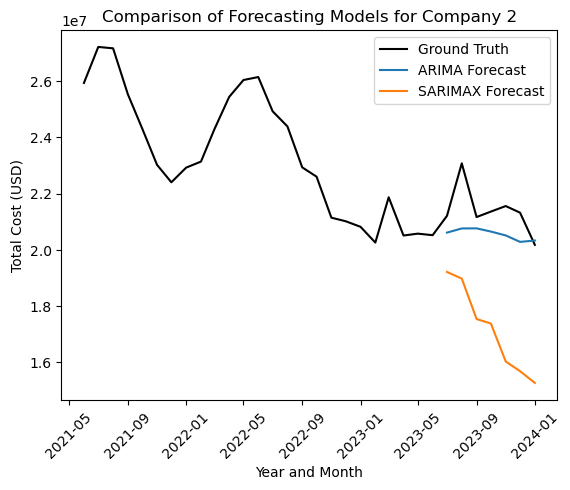

In [41]:
# Print RMSE for each model
print("ARIMA RMSE:", np.round(arima_rmse,2))
print("SARIMAX RMSE:", np.round(sarimax_rmse, 2))
print("ARIMA Relative RMSE:", np.round(arima_relative_rmse, 2))
print("SARIMAX Relative RMSE:", np.round(sarimax_relative_rmse, 2))

# Visualization
plt.figure()
plt.plot(Company2_tsa['Year_Month'], Company2_tsa['Amount_Allowed_6_month_avg'], label='Ground Truth', color='black')
plt.plot(test['Year_Month'], arima_forecast, label='ARIMA Forecast')
plt.plot(test['Year_Month'], sarimax_forecast, label='SARIMAX Forecast')
plt.xlabel('Year and Month')
plt.xticks(rotation=45)
plt.ylabel('Total Cost (USD)')
plt.title('Comparison of Forecasting Models for Company 2')
plt.legend()
plt.show()